<a href="https://colab.research.google.com/github/BarGinger/ExplainableAIRadiology/blob/main/ex_1_final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable AI in a Radiology Scenario

### Group Number: 1

### Teammates:
1. **Abhinav Atmuri**
2. **Bar Melinarskiy**
3. **Konstantinos Zavantias**
4. **Nikita Aksjonov**

### Model Used: **Densenet-169**

### Quantus Quantitative Evaluation: **GradCAM**

## Imports entire notebook

In [49]:
# Helper function to check if the code is running in Google Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Usage
if is_colab():
    print("Running in Google Colab")
else:
    print("Not running in Google Colab")

# Enable the widgets extension for JupyterLab
%pip install jupyterlab_widgets
%pip install ipywidgets
%pip install --upgrade torchsummary
%pip install torch-summary
%pip install onnx

# Importing libraries
import pandas as pd
import numpy as np
from IPython.display import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast  # Add these imports for mixed precision training
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchsummary import summary
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, ndcg_score
from tqdm.notebook import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import shutil
import subprocess
import zipfile
import re
import cv2
import random


# Importing libraries for model interpretability
%pip install lime
import lime.lime_tabular
import lime.lime_image

%pip install grad-cam
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import quantus

Not running in Google Colab
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Global Definitions

In [5]:
# Global helper functions
def get_class_names():
    return [
        'Pleural Effusion'
    ]

def get_policies():
    return [
        'ones',
        'zeroes',
        'mixed'
    ]

# Global variables

# Define the class names for the medical conditions
class_names = get_class_names()

# Define the policies for dataset preparation
policies = get_policies()

# Path to the zip file
zip_path = "./chexpert.zip"

# Path to the zip file in Google Drive
zip_file_in_drive = '/content/drive/MyDrive/chexpert.zip'  # Change this to your desired location

# Path to the directory where the datasets will be extracted
data_dir = "./CheXpert-v1.0-small"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the batch size
batch_size = 32

# Flag whether to modify the first layer of the model, meaning if we converted to gray scale and did not use tranformation to 3 channels
modify_first_layer = True

last_shape = 3
if modify_first_layer:
    last_shape = 1

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

In [6]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.5.1+cu121
12.1
90100
True


## Dataset class

In [7]:
class CheXpertDataset(Dataset):
    def __init__(self, dataframe, class_names, zip_path, transform=None):
        # Initialize the dataset with a dataframe, class names, zip path, and optional transform
        self.dataframe = dataframe
        self.class_names = class_names
        self.transform = transform  # Use this later on to resize images and pre-process if needed

    def __len__(self):
        # Return the length of the dataframe, which is the number of samples in the dataset
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the image path from the dataframe at the given index
        img_path = self.dataframe.iloc[idx]['path']
        FOLDER = ""  # Define the folder path if needed
        img_path = FOLDER + img_path
        # Open the image and convert it to RGB
        image = Image.open(img_path).convert("RGB")
        # Get the labels for the image from the dataframe and convert them to float32
        labels = self.dataframe.iloc[idx][self.class_names].values.astype('float32')
        # Convert the labels to a torch tensor
        labels = torch.tensor(labels, dtype=torch.float32)

        # Apply the transform to the image if provided
        if self.transform:
            image = self.transform(image)

        # Return the image and labels
        return image, labels

## Model Definitions

We experimented with various models, including DenseNet121, DenseNet169, DenseNet201, and a stacked model combining DenseNet169 and MobileNet_v2. Ultimately, we settled on DenseNet169.

In [8]:
class StackedModel(nn.Module):
    def __init__(self, n_labels, freeze_layers, modify_first_layer=False):
        super(StackedModel, self).__init__()
        self.base_model1 = models.mobilenet_v2(pretrained=True)
        self.base_model2 = models.densenet169(pretrained=True)

        if modify_first_layer:
            # Modify the first convolutional layer to accept 1-channel input for MobileNetV2
            self.base_model1.features[0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

            # Modify the first convolutional layer to accept 1-channel input for DenseNet169
            self.base_model2.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        if freeze_layers:
            for param in self.base_model1.parameters():
                param.requires_grad = False
            for param in self.base_model2.parameters():
                param.requires_grad = False

        self.base_model1.classifier = nn.Identity()
        self.base_model2.classifier = nn.Identity()

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(1664 + 1280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, n_labels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.base_model1.features(x)
        x1 = self.global_avg_pool(x1)
        x1 = torch.flatten(x1, 1)

        x2 = self.base_model2.features(x)
        x2 = self.global_avg_pool(x2)
        x2 = torch.flatten(x2, 1)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

def upload_stacked_models(n_labels=1, freeze_layers=True, modify_first_layer=False):
    """
    Create a stacked model using DenseNet169 and MobileNetV2 as base models.

    Parameters:
    - n_labels: Number of output labels (classes).
    - freeze_layers: Boolean indicating whether to freeze the original layers.

    Returns:
    - The stacked model.
    """
    model = StackedModel(n_labels, freeze_layers, modify_first_layer=modify_first_layer)
    return model

def upload_pretrained_densenet169(add_layers=True, n_labels=1, freeze_layers=True, unfreeze_modules=['features.denseblock4'],
                                  modify_first_layer=False):
    """
    Modify a pre-trained DenseNet169 model by adding custom layers and optionally freezing the original layers.

    Parameters:
    - add_layers: Boolean indicating whether to add custom layers.
    - n_labels: Number of output labels (clupload_pretrained_densenet169asses).
    - freeze_layers: Boolean indicating whether to freeze the original layers.
    - unfreeze_modules: List of layer names or indices to unfreeze (e.g., 'features.denseblock4').

    Returns:
    - The modified model.
    """

    # Load the pre-trained DenseNet169 model with ImageNet weights
    pretrained_model = models.densenet169(weights=models.DenseNet169_Weights.IMAGENET1K_V1)

    # Step 1: Freeze all layers
    if freeze_layers:
        for param in pretrained_model.parameters():
            param.requires_grad = False

    # Step 2: Unfreeze specific layers (if specified)
    if unfreeze_modules:
        for name, child in pretrained_model.named_modules():
            if any(layer_name in name for layer_name in unfreeze_modules):
                for param in child.parameters():
                    param.requires_grad = True

    # Step 3: Modify the first convolutional layer to accept 1-channel input for DenseNet169
    if modify_first_layer:
        pretrained_model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Step 4: Add custom layers if specified
    if add_layers:
        in_features = pretrained_model.classifier.in_features
        pretrained_model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, n_labels)
        )

    return pretrained_model

def upload_pretrained_densenet201(add_layers=True, n_labels=1, freeze_layers=True, unfreeze_modules=['features.denseblock4'],
                                  modify_first_layer=False):
    """
    Modify a pre-trained DenseNet201 model by adding custom layers and optionally freezing the original layers.

    Parameters:
    - pretrained_model: The pre-trained model to be modified.
    - add_layers: Boolean indicating whether to add custom layers.
    - n_labels: Number of output labels (classes).
    - freeze_layers: Boolean indicating whether to freeze the original layers.
    - unfreeze_modules: List of layer names or indices to unfreeze (e.g., 'features.denseblock4').
    - modify_first_layer: Boolean indicating whether to modify the first conv layer for single-channel input.

    Returns:
    - The modified model.
    """
    # Load the pre-trained DenseNet201 model with ImageNet weights
    pretrained_model = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)

    # Step 1: Freeze all layers
    if freeze_layers:
        for param in pretrained_model.parameters():
            param.requires_grad = True # change it to train everything

    # Step 2: Unfreeze specific layers (if specified)
    if unfreeze_modules:
        for name, child in pretrained_model.named_modules():
            if any(layer_name in name for layer_name in unfreeze_modules):
                for param in child.parameters():
                    param.requires_grad = True

    # Step 3: Modify the first convolutional layer to accept 1-channel input for DenseNet201
    if modify_first_layer:
        pretrained_model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Step 4: Add custom layers if specified
    if add_layers:
        in_features = pretrained_model.classifier.in_features
        pretrained_model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, n_labels)
        )

    return pretrained_model


def upload_pretrained_densenet121(pretrained_model, add_layers=True, n_labels=1, freeze_layers=True):
    """
    Modify a pre-trained DenseNet121 model by adding custom layers and optionally freezing the original layers.

    Parameters:
    - pretrained_model: The pre-trained model to be modified.
    - add_layers: Boolean indicating whether to add custom layers.
    - n_labels: Number of output labels (classes).
    - freeze_layers: Boolean indicating whether to freeze the original layers.

    Returns:
    - The modified model.
    """
    if freeze_layers:
        for param in pretrained_model.parameters():
            param.requires_grad = False

    if add_layers:
        in_features = pretrained_model.classifier.in_features
        pretrained_model.classifier = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(32, n_labels)
        )

    return pretrained_model

# Preprocessing utils functions

In [9]:
# Global preprocessing functions
def prepare_dataset(dataframe, policy, class_names):
    """
    Prepare the dataset by filtering, shuffling, and filling missing values.

    Parameters:
    - dataframe: The input DataFrame containing the dataset.
    - policy: The policy to handle uncertain labels (-1). Options are "ones", "zeroes", "mixed".
    - class_names: List of class names for the medical conditions.

    Returns:
    - x_path: Numpy array of image paths.
    - y: Numpy array of labels corresponding to the class names.
    """
    
    # Filter the dataset to include only frontal images
    dataset_df = dataframe[dataframe['Frontal/Lateral'] == 'Frontal']
    dataset_df = dataset_df.dropna(subset=['Pleural Effusion'])

    # Extract image paths and labels
    x_path = dataset_df["Path"].to_numpy()
    y_df = dataset_df[class_names]

    # Define classes to be treated as ones in the "mixed" policy
    class_ones = ['Atelectasis', 'Cardiomegaly']

    # Initialize the labels array
    y = np.empty(y_df.shape, dtype=int)

    # Define a dictionary to map policies to their corresponding actions
    policy_actions = {
        "ones": lambda cls: 1,
        "zeroes": lambda cls: 0,
        "mixed": lambda cls: 1 if cls in class_ones else 0
    }

    # Iterate over each row in the labels DataFrame
    for i, (index, row) in enumerate(y_df.iterrows()):
        labels = []
        for cls in class_names:
            curr_val = row[cls]
            if curr_val:
                curr_val = float(curr_val)
                if curr_val == 1:
                    feat_val = 1
                elif curr_val == -1:
                    feat_val = policy_actions.get(policy, lambda cls: 0)(cls)
                else:
                    feat_val = 0
            else:
                feat_val = 0
            labels.append(feat_val)
        y[i] = labels

    return x_path, y

def split_train_val(train_df, policy, class_names, test_size=0.2, random_state=42):
    """
    Split the training data into training and validation sets.

    Parameters:
    - train_df: DataFrame containing the training data.
    - policy: The policy to handle uncertain labels (-1). Options are "ones", "zeroes", "mixed".
    - class_names: List of class names for the medical conditions.
    - test_size: Proportion of the training data to include in the validation set.
    - random_state: Random seed for reproducibility.

    Returns:
    - train_df: DataFrame containing the training data.
    - val_df: DataFrame containing the validation data.
    """
    # Prepare the training dataset
    train_paths, train_labels = prepare_dataset(train_df, policy, class_names)

    # Split the training dataset into training and validation sets
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=test_size, random_state=random_state
    )

    # Create DataFrames for the training and validation sets
    train_df = pd.DataFrame({'path': train_paths})
    train_labels_df = pd.DataFrame(train_labels, columns=class_names)
    train_df = pd.concat([train_df, train_labels_df], axis=1)

    val_df = pd.DataFrame({'path': val_paths})
    val_labels_df = pd.DataFrame(val_labels, columns=class_names)
    val_df = pd.concat([val_df, val_labels_df], axis=1)

    return train_df, val_df

def prepare_test_dataset(valid_df, policy, class_names):
    """
    Prepare the test dataset (original validation set).

    Parameters:
    - valid_df: DataFrame containing the original validation data.
    - policy: The policy to handle uncertain labels (-1). Options are "ones", "zeroes", "mixed".
    - class_names: List of class names for the medical conditions.

    Returns:
    - test_df: DataFrame containing the test data.
    """
    # Prepare the test dataset
    test_paths, test_labels = prepare_dataset(valid_df, policy, class_names)

    # Create DataFrame for the test set
    test_df = pd.DataFrame({'path': test_paths})
    test_labels_df = pd.DataFrame(test_labels, columns=class_names)
    test_df = pd.concat([test_df, test_labels_df], axis=1)

    return test_df

def get_datasets(zip_path='chexpert.zip', train_csv='train.csv', validation_csv='validation.csv', test_csv='test.csv'):
    """
    Get the training, validation, and test datasets.

    Parameters:
    - zip_path: Path to the zip file containing the dataset.
    - train_csv: Path to the CSV file for the training data.
    - validation_csv: Path to the CSV file for the validation data.
    - test_csv: Path to the CSV file for the test data.

    Returns:
    - train_df: DataFrame containing the training data.
    - validation_df: DataFrame containing the validation data.
    - test_df: DataFrame containing the test data.
    """
    # Check if the CSV files exist
    if os.path.exists(train_csv) and os.path.exists(validation_csv) and os.path.exists(test_csv):
        # Load the datasets from the CSV files
        train_df = pd.read_csv(prefix_path + train_csv)
        validation_df = pd.read_csv(prefix_path + validation_csv)
        test_df = pd.read_csv(prefix_path + test_csv)
        print("Loaded datasets from CSV files.")
    else:
        # Read the training and validation data from the zip file
        original_train_df, test_df = read_zip(zip_path=zip_path)

        # Count the occurrences of each unique value in the "Pleural Effusion" column
        pleural_effusion_counts = original_train_df['Pleural Effusion'].value_counts()
        print(f"in original_train_df Count for each class:\n{pleural_effusion_counts}")

        policies = get_policies()
        class_names = get_class_names()

        # Select the policy to handle uncertain labels (-1)
        selected_policy = policies[0]

        # Split the original training data into separate training and validation sets
        train_df, validation_df = split_train_val(original_train_df, selected_policy, class_names)

        # Prepare the test dataset
        test_df = prepare_test_dataset(test_df, selected_policy, class_names)

        # check if the directory exists
        if not os.path.exists('dataset'):
        # Create the folder if it doesn't exist
            os.makedirs('dataset')
            print("Folder 'dataset' created successfully.")
        else:
            print("Folder 'dataset' already exists.")
        
        # Export the datasets to CSV files
        prefix_path = 'dataset/'
        train_df.to_csv(prefix_path+ train_csv, index=False)
        validation_df.to_csv(prefix_path + validation_csv, index=False)
        test_df.to_csv(prefix_path + test_csv, index=False)
        print("Exported datasets to CSV files.")

    return train_df, validation_df, test_df

def read_zip(zip_path='chexpert.zip'):
    """
    Read training and validation data from a zip file.

    Parameters:
    - zip_path: Path to the zip file containing the dataset.

    Returns:
    - original_train_df: DataFrame containing the original training data.
    - test_df: DataFrame containing the original validation data.
    """
    original_train_df, test_df = None, None

    # Read CSV files from the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open('train.csv') as train_file:
            original_train_df = pd.read_csv(train_file)
        with zip_ref.open('valid.csv') as valid_file:
            test_df = pd.read_csv(valid_file)

    return original_train_df, test_df

# Helper function to apply albumentations inside torchvision pipeline
class AlbumentationsWrapper:
    def __init__(self, albumentations_transform):
        self.albumentations_transform = albumentations_transform

    def __call__(self, img):
        img = np.array(img)  # Convert PIL image to numpy
        # Apply the transform with the named argument 'image'
        img = self.albumentations_transform(image=img)["image"]
        # Convert the image to a PyTorch tensor with resizable storage
        img = torch.from_numpy(np.array(img)).type(torch.FloatTensor)
        return img

def get_transform(augment=False):
    """
    Define the transformation pipeline for the images.

    Parameters:
    - augment: Whether to apply data augmentation.

    Returns:
    - transform: Composed transformation pipeline.
    """

    transform_list = [
        A.Resize(224, 224),  # Resize images to 224x224 pixels
        A.ToGray(p=1.0, num_output_channels=1, method="pca"),  # Convert to grayscale
        A.Normalize(mean=(0.5,), std=(0.5,)),  # Normalize grayscale images
    ]

    if augment:
        transform_list.extend([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ElasticTransform(alpha=1, sigma=50, p=0.5),  # Removed alpha_affine
            A.GaussianBlur(p=0.2),
            A.Rotate(limit=10, p=0.5),
            # Using Affine instead of ShiftScaleRotate
            A.Affine(
                scale=(0.9, 1.1),  # Scale factor range
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},  # Translation range
                rotate=(-10, 10),  # Rotation range in degrees
                p=0.5  # Probability of applying the transform
            ),
            # Replaced CropAndPad with Crop
            A.Crop(x_min=0, y_min=0, x_max=224, y_max=224, p=0.5),
            A.RandomCrop(height=224, width=224, p=0.5) #This will randomly crop the image, hopefully focusing on different areas
        ])

    transform_list.append(ToTensorV2())

    #Wrap the list in albumentation wrapper
    albumentations_transform = A.Compose(transform_list, p=1.0, bbox_params=None, keypoint_params=None, additional_targets=None)

    #return a wrapper to apply the transformation with additional_target
    return AlbumentationsWrapper(albumentations_transform)

def transform_dataset(df, zip_path='chexpert.zip', batch_size=16, shuffle=True, augment=False, sampler=False, num_workers=2):
    """
    Transform the dataset into DataLoader objects for given dataframe.

    Parameters:
    - df: DataFrame containing the dataset.
    - zip_path: Path to the zip file containing the images.
    - batch_size: Number of samples in each batch.
    - shuffle: Whether to shuffle the data.
    - augment: Whether to apply data augmentation.
    - sampler (bool): Whether to use a sampler for the DataLoader.
    - num_workers: Number of worker processes for data loading.

    Returns:
    - dataset: CheXpertDataset object containing the dataset.
    - loader: DataLoader object containing the dataset.
    - images: Batch of images from the DataLoader.
    - labels: Batch of labels from the DataLoader.
    """
    # Define the class names for the medical conditions
    class_names = get_class_names()

    # Get the transformation pipeline
    transformer = get_transform(augment=augment)

    # Create the dataset with the defined transformations
    dataset = CheXpertDataset(dataframe=df, class_names=class_names, zip_path=zip_path, transform=transformer)

    if sampler:
        # Calculate class weights
        class_counts = df['Pleural Effusion'].value_counts()
        class_weights = 1. / class_counts
        sample_weights = df['Pleural Effusion'].map(class_weights)
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

        # Use the sampler in the DataLoader
        loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers, pin_memory=True)
    else:
        # Create DataLoader for the dataset
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True)

    # Verify data loading by fetching a batch of images and labels from the DataLoader
    images, labels = next(iter(loader))

    return dataset, loader, images, labels

# Model training utils functions

In [10]:
## Helper functions for training PyTorch models.
def train_model(model, train_loader: DataLoader, test_loader: DataLoader, criterion, optimizer, scheduler, num_epochs=5, model_name='model', device='cuda', patience=5, num_workers=2):
    """
    Train a PyTorch model with the given parameters.

    Parameters:
    - model: The PyTorch model to be trained.
    - train_loader: DataLoader for the training dataset.
    - test_loader: DataLoader for the validation dataset.
    - criterion: The loss function.
    - optimizer: The optimizer.
    - scheduler: The learning rate scheduler.
    - num_epochs: Number of epochs to train the model.
    - model_name: Name to save the trained model.
    - device: Device to train the model on ('cpu' or 'cuda').
    - patience: Number of epochs to wait for improvement before stopping early.
    - num_workers: Number of worker processes for data loading.

    Returns:
    - train_losses: List of training losses for each epoch.
    - train_accuracies: List of training accuracies for each epoch.
    - test_losses: List of validation losses for each epoch.
    - test_accuracies: List of validation accuracies for each epoch.
    - test_aucs: List of validation AUCs for each epoch.
    """
    model.to(device)

    # Check if the folder exists
    if not os.path.exists('finetuned_models'):
        # Create the folder if it doesn't exist
        os.makedirs('finetuned_models')
        print("Folder 'finetuned_models' created successfully.")
    else:
        print("Folder 'finetuned_models' already exists.")

    scaler = amp.GradScaler(device=device)  # Initialize the GradScaler for mixed precision training
    save_path = f"finetuned_models/{model_name}.pkl"

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    test_aucs = []

    best_loss = float('inf')
    epochs_no_improve = 0

    print(f"Training {model_name} model for {num_epochs} epochs")
    for epoch in range(num_epochs):
        model.train()
        total_train = 0
        correct_train = 0
        train_loss = 0.0

        # Add a progress bar for the training loop
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                # Flatten the labels if needed
                # labels = labels.squeeze(1)

                optimizer.zero_grad()
                with amp.autocast(device_type="cuda", dtype=torch.float16):  # Use autocast for mixed precision training
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()  # Scale the loss for mixed precision training
                scaler.step(optimizer)
                scaler.update()

                # Accuracy and loss calculation
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                # Calculate accuracy per sample (averaged over labels)
                correct_train += (predicted == labels).sum().item() / labels.size(1)
                total_train += labels.size(0)
                train_loss += loss.item()

                pbar.update(1)

        # Store the average metrics for this epoch
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Evaluation phase (Test set)
        model.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0.0
        all_labels = []
        all_outputs = []

        with tqdm(total=len(test_loader), desc=f"Epoch {epoch+1}/{num_epochs} - Evaluation", unit="batch") as pbar:
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    predicted = (torch.sigmoid(outputs) > 0.5).float()
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item() / labels.size(1)
                    test_loss += criterion(outputs, labels).item()

                    all_labels.append(labels.cpu().numpy())
                    all_outputs.append(outputs.cpu().numpy())

                    pbar.update(1)

        test_accuracy = correct_test / total_test
        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        # Calculate AUC
        all_labels = np.concatenate(all_labels)
        all_outputs = np.concatenate(all_outputs)
        test_auc = roc_auc_score(all_labels, all_outputs)
        test_aucs.append(test_auc)

        # Print the results for this epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}, Test AUC: {test_aucs[-1]:.4f}")

        # Plot ROC curve using the plot_roc_curve function
        plot_roc_curve(all_labels, all_outputs, model_name=model_name, dataset='validation', epoch=epoch + 1)

        # Early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            print(f"Saved new best model for epoch {epoch + 1} for model {model_name}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1} for model {model_name}")
                break

        # Adjust the learning rate based on the validation loss
        scheduler.step(test_loss)

    save_model(model, model_name=model_name, device=device)

    return train_losses, train_accuracies, test_losses, test_accuracies, test_aucs

def save_model(model, model_name, device='cuda'):
    """
    Save a PyTorch model to a file using pickle and ONNX.

    Parameters:
    - model: The PyTorch model to be saved.
    - model_name: The name of the model to save.
    - device: Device to save the model on ('cpu' or 'cuda').
    """
    pickle_path = f"finetuned_models/{model_name}.pkl"
    print(f"Model pickled saved in {pickle_path}")
    torch.save(model, pickle_path)

    pth_path = f"finetuned_models/{model_name}.pth"
    print(f"Model pth saved in {pth_path}")
    torch.save(model.state_dict(), pth_path)

    # Define dummy input for ONNX export (batch size 1, 1 channel, 224x224 image size)
    dummy_input = torch.randn(1, last_shape, 224, 224).to(device)

    # Export the model to ONNX format
    onnx_path = f"finetuned_models/{model_name}.onnx"
    torch.onnx.export(model, dummy_input, onnx_path,
                      input_names=["input"],
                      output_names=["output"],
                      opset_version=11)

    print(f"Model saved as onnx in {onnx_path}")

def load_model(filename, device='cuda'):
    """
    Load a PyTorch model from a file.

    Parameters:
    - filename: The name of the file to load the model from.
    - device: Device to load the model on ('cpu' or 'cuda').

    Returns:
    - The loaded PyTorch model.
    """
    path = f"finetuned_models/{filename}"
    loaded_model = torch.load(path, map_location=device)
    return loaded_model

def predict_model(model, loader, device='cuda'):
    """
    Predict using a trained PyTorch model.

    Parameters:
    - model: The trained PyTorch model.
    - loader: DataLoader for the dataset to predict on.
    - device: Device to run the predictions on ('cpu' or 'cuda').

    Returns:
    - predictions: Numpy array of predictions.
    - labels: Numpy array of true labels.
    """
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

def plot_roc_curve(labels, preds, model_name, dataset='test', epoch=None, title_text=None):
    """
    Plot the ROC curve for the given model.

    Parameters:
    - labels: Numpy array of true labels.
    - preds: Numpy array of predicted probabilities.
    - model_name: Name of the model.
    - dataset: Name of the dataset (e.g., 'train', 'validation', 'test').
    - epoch: Epoch number (optional).

    Returns:
    - None
    """
    class_names = get_class_names()
    color = "orange"
    if epoch is not None:
        color = "blue"

    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})', color=color)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    if title_text is None:
        title_text = f'ROC Curve for {model_name} on {dataset} dataset'
    if epoch is not None:
        title_text += f' (Epoch {epoch})'
    plt.title(title_text, fontsize=16, fontdict={'color': 'blue', 'weight': 'bold'})
    plt.legend(loc='lower right', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid()
    plt.show()

### Download Dataset from Kaggle or Google Drive (if not available in current env)

In [11]:
# If we are in colab and we need to mount the drive
if is_colab():
  from google.colab import drive
  # Mount Google Drive
  drive.mount('/content/drive')
  print("Google Drive mounted successfully.")
else:
  print("Not in Google Colab.")

Not in Google Colab.


In [12]:
# Check if Google Drive is mounted and the zip file exists
drive_mounted = os.path.exists('/content/drive')
zip_in_drive = os.path.exists(zip_file_in_drive)

# Check if the dataset is already downloaded locally, if not download it
print(f"Checking if dataset zip file exists at {zip_path}")
if not os.path.exists(zip_path):
    # Use the zip file from Google Drive if available, otherwise download
    print("Dataset zip file not found locally, searching in drive if connected.")
    if drive_mounted and zip_in_drive:
        print("Using dataset from Google Drive.")
        zip_path = zip_file_in_drive  # Update zip_path to use the Drive location
    else:
        print("Downloading the dataset...")
        # Check if kaggle is installed
        try:
            subprocess.run(["kaggle", "--version"], check=True)
            print("Kaggle is already installed.")
        except subprocess.CalledProcessError:
            print("Kaggle is not installed. Installing kaggle...")
            %pip install kaggle

        # Check if the kaggle.json file exists in the destination
        kaggle_json_path = os.path.expanduser('~/.kaggle/kaggle.json')
        if not os.path.exists('kaggle.json') and not os.path.exists(kaggle_json_path):
            # Move kaggle.json to ~/.kaggle
            os.makedirs(os.path.dirname(kaggle_json_path), exist_ok=True)
            shutil.move('kaggle.json', kaggle_json_path)
            # Set permissions
            os.chmod(kaggle_json_path, 0o600)
        else:
            print("kaggle.json already exists in the destination.")

        # Download the dataset from Kaggle
        subprocess.run(["kaggle", "datasets", "download", "-d", "ashery/chexpert"], check=True)
        print("Dataset was downloaded from Kaggle.")

        if drive_mounted:
            print("Saving dataset to Google Drive for future use.")
            shutil.copy(zip_path, zip_file_in_drive)
            print(f"Dataset saved to {zip_file_in_drive}")

else:
    print("Dataset already downloaded.")

Checking if dataset zip file exists at ./chexpert.zip
Dataset already downloaded.


### Extract the Zip File to Improve Performance

Our training and prediction code assumes that the zip file has been extracted as running the code without extracting the zip file will result in significantly slower performance.

In [13]:
# Check if the dataset is already extracted, if not extract it
if not os.path.exists(data_dir):
    print("Extracting the dataset...")
    #unzip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    #list files in the extracted dir
    os.listdir(data_dir)
else:
    print("Dataset already extracted.")

Dataset already extracted.


### Load train, validtion and test datasets

In [14]:
# Load the datasets
train_df, validation_df, test_df = get_datasets(zip_path)

if train_df is None or validation_df is None or test_df is None:
    print("Error loading the datasets.")
else:
    print("Datasets loaded successfully.")

in original_train_df Count for each class:
Pleural Effusion
 1.0    86187
 0.0    35396
-1.0    11628
Name: count, dtype: int64
Folder 'dataset' already exists.
Exported datasets to CSV files.
Datasets loaded successfully.


#### Peak into training dataset

In [15]:
# Print some information about the train DataFrame
display(train_df.head())
print("Number of rows and columns in the train DataFrame:", train_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(train_df.dtypes)

# Count the occurrences of each unique value in the "Pleural Effusion" column
pleural_effusion_counts = train_df['Pleural Effusion'].value_counts()

# Print the counts for each class
print(f"Count for each class:\n{pleural_effusion_counts}")

path  Pleural Effusion
0  CheXpert-v1.0-small/train/patient16646/study1/...                 1
1  CheXpert-v1.0-small/train/patient10056/study9/...                 1
2  CheXpert-v1.0-small/train/patient42372/study4/...                 1
3  CheXpert-v1.0-small/train/patient45046/study5/...                 1
4  CheXpert-v1.0-small/train/patient05198/study2/...                 0

Number of rows and columns in the train DataFrame: (89420, 2)
Column names and data types:
path                object
Pleural Effusion     int32
dtype: object
Count for each class:
Pleural Effusion
1    69302
0    20118
Name: count, dtype: int64


### Peak into the validation dataset

In [16]:
# Print some information about the validtion DataFrame
# Set pandas display options to show all columns
display(validation_df.head())
print("Number of rows and columns in the validation DataFrame:", validation_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(validation_df.dtypes)

# Count the occurrences of each unique value in the "Pleural Effusion" column
pleural_effusion_counts = validation_df['Pleural Effusion'].value_counts()

# Print the counts for each class
print(f"Count for each class:\n{pleural_effusion_counts}")

path  Pleural Effusion
0  CheXpert-v1.0-small/train/patient48924/study2/...                 1
1  CheXpert-v1.0-small/train/patient38687/study1/...                 1
2  CheXpert-v1.0-small/train/patient03187/study2/...                 1
3  CheXpert-v1.0-small/train/patient37033/study15...                 1
4  CheXpert-v1.0-small/train/patient25492/study1/...                 0

Number of rows and columns in the validation DataFrame: (22356, 2)
Column names and data types:
path                object
Pleural Effusion     int32
dtype: object
Count for each class:
Pleural Effusion
1    17175
0     5181
Name: count, dtype: int64


#### Peak into the test dataset

In [17]:
# Print some information about the train DataFrame
# Set pandas display options to show all columns
display(test_df.head())
print("Number of rows and columns in the test DataFrame:", test_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(test_df.dtypes)


# Count the occurrences of each unique value in the "Pleural Effusion" column
pleural_effusion_counts = test_df['Pleural Effusion'].value_counts()

# Print the counts for each class
print(f"Count for each class:\n{pleural_effusion_counts}")

path  Pleural Effusion
0  CheXpert-v1.0-small/valid/patient64541/study1/...                 0
1  CheXpert-v1.0-small/valid/patient64542/study1/...                 0
2  CheXpert-v1.0-small/valid/patient64543/study1/...                 0
3  CheXpert-v1.0-small/valid/patient64544/study1/...                 0
4  CheXpert-v1.0-small/valid/patient64545/study1/...                 1

Number of rows and columns in the test DataFrame: (202, 2)
Column names and data types:
path                object
Pleural Effusion     int32
dtype: object
Count for each class:
Pleural Effusion
0    138
1     64
Name: count, dtype: int64


#### Dataset Preparation for PyTorch (Using DataLoaders)

In [18]:
num_of_workers = 0
if is_colab():
    num_of_workers = 4

# Transform the training dataset
train_dataset, train_loader, train_images, train_labels = transform_dataset(train_df, zip_path, batch_size=batch_size, shuffle=True, augment=True, sampler=True, num_workers=num_of_workers)

# Transform the validation dataset
validtion_dataset, validation_loader, validtion_images, validtion_labels = transform_dataset(validation_df, zip_path, batch_size=batch_size, shuffle=False, augment=False, num_workers=num_of_workers)

# Transform the test dataset
test_dataset, test_loader, test_images, test_labels = transform_dataset(test_df, zip_path, batch_size=batch_size, shuffle=False, augment=False, num_workers=num_of_workers)

#### Visualising example

Image 7, Label: 1.0
Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


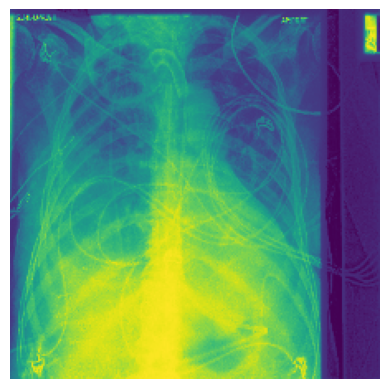

Image 6, Label: 1.0
Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


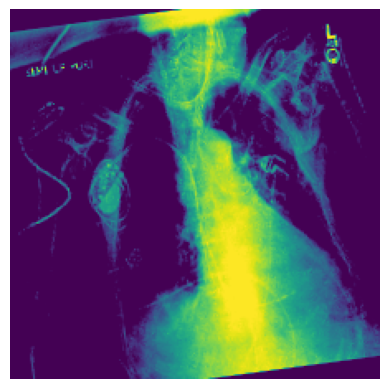

Image 25, Label: 1.0
Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


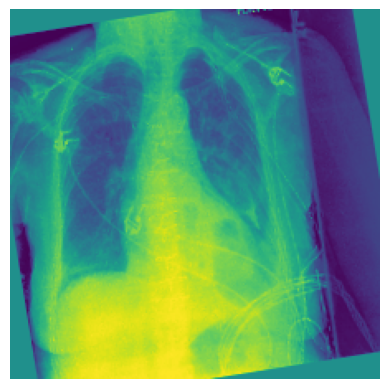

Image 4, Label: 0.0
Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


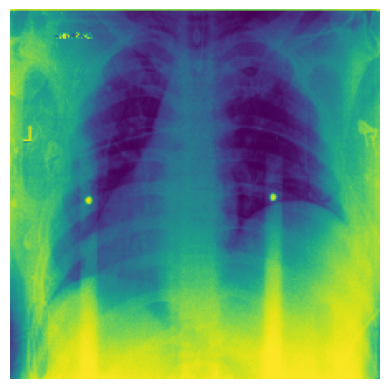

Image 13, Label: 0.0
Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


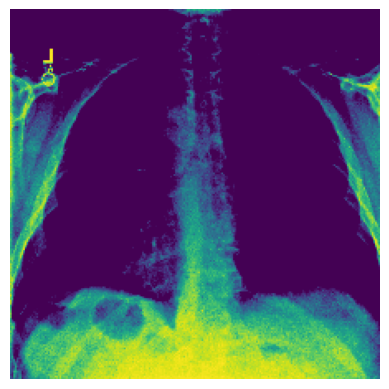

In [19]:
# Select 5 random images from the dataset
random_indices = random.sample(range(len(train_images)), 5)

for i in random_indices:
    image = train_images[i]
    label = train_labels[i]
    print(f"Image {i}, Label: {label.item()}")
    original_shape = image.shape
    image = image.permute(1, 2, 0).numpy()  # Change shape to (224, 224, last_shape)
    new_shape = image.shape
    print(f"Original shape: {original_shape}, New shape: {new_shape}")
    # Check the shape of the image to ensure it is (224, 224, last_shape)
    assert new_shape == (224, 224, last_shape), f"Expected shape (224, 224, {last_shape}), but got {image.shape}"

    # Denormalize the image for visualization
    image = (image * 0.5) + 0.5

    # Plot the image
    print("Example image:")
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

# Choose model to train, execute only the one you wish to train
Skip this part if you only want to evaluate the trained model.

In [23]:
# Load and modify a pre-trained DenseNet169 model

# Parameters:
# - add_layers: Add custom layers to the model
# - n_labels: Number of output labels (classes)
# - freeze_layers: Freeze the layers of the pre-trained model to prevent them from being updated during training
# - modify_first_layer: Modify the first layer to accept different input channels if needed

# Modify the DenseNet169 model by adding custom layers and optionally freezing certain layers
model = upload_pretrained_densenet169(add_layers=True, n_labels=len(class_names), freeze_layers=False, modify_first_layer=modify_first_layer)

# Move the model to the appropriate device (e.g., 'cuda' for GPU or 'cpu' for CPU)
model.to(device)

# Define the model name for saving purposes
model_name = "densenet169"

#### Here we can extract different pre-trained models

### Train DenseNet201

In [22]:
# Load and modify a pre-trained DenseNet201 model

# Parameters:
# - pretrained: Use a pre-trained version of DenseNet201 with ImageNet weights
# - add_layers: Add custom layers to the model
# - n_labels: Number of output labels (classes)
# - freeze_layers: Freeze the layers of the pre-trained model to prevent them from being updated during training
# - modify_first_layer: Modify the first layer to accept different input channels if needed

# Modify the DenseNet201 model by adding custom layers and optionally freezing certain layers
model = upload_pretrained_densenet201(add_layers=True, n_labels=len(class_names), freeze_layers=True, modify_first_layer=modify_first_layer)

# Move the model to the appropriate device (e.g., 'cuda' for GPU or 'cpu' for CPU)
model.to(device)

# Define the model name for saving purposes
model_name = "densenet201"

#### Summary of Model

In [24]:
# Display the model summary, input size (last_shape (1 or 3) channel/s, 224x224 image)
summary(model, input_size=(last_shape, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       3,136
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             45,440
|    |    └─_DenseLayer: 3-2             49,600
|    |    └─_DenseLayer: 3-3             53,760
|    |    └─_DenseLayer: 3-4             57,920
|    |    └─_DenseLayer: 3-5             62,080
|    |    └─_DenseLayer: 3-6             66,240
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             512
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  32,768
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            53,760
|    |    └─_DenseLayer: 3-12            57,920
|    |    └─_DenseLayer: 3-13 

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       3,136
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             45,440
|    |    └─_DenseLayer: 3-2             49,600
|    |    └─_DenseLayer: 3-3             53,760
|    |    └─_DenseLayer: 3-4             57,920
|    |    └─_DenseLayer: 3-5             62,080
|    |    └─_DenseLayer: 3-6             66,240
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             512
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  32,768
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            53,760
|    |    └─_DenseLayer: 3-12            57,920
|    |    └─_DenseLayer: 3-13 

### Training the model

Training densenet169 model for 25 epochs


Epoch 1/25 - Training:   0%|          | 0/2795 [00:00<?, ?batch/s]

Epoch 1/25 - Evaluation:   0%|          | 0/699 [00:00<?, ?batch/s]

Epoch [1/25], Train Loss: 0.3393, Train Accuracy: 0.8683, Test Loss: 0.3212, Test Accuracy: 0.8628, Test AUC: 0.9417


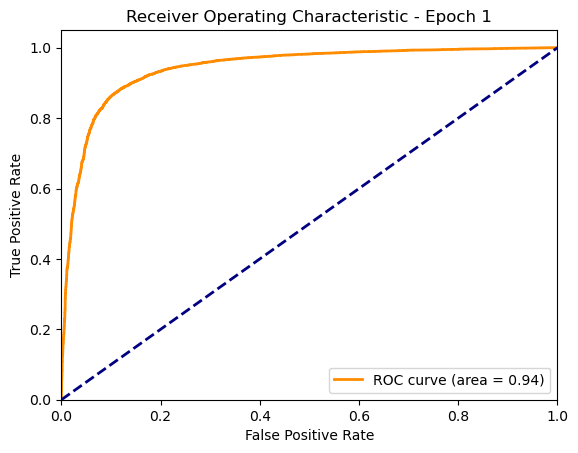

Saved new best model for epoch 1 for model densenet169


Epoch 2/25 - Training:   0%|          | 0/2795 [00:00<?, ?batch/s]

Epoch 2/25 - Evaluation:   0%|          | 0/699 [00:00<?, ?batch/s]

Epoch [2/25], Train Loss: 0.3282, Train Accuracy: 0.8741, Test Loss: 0.3457, Test Accuracy: 0.8609, Test AUC: 0.9430


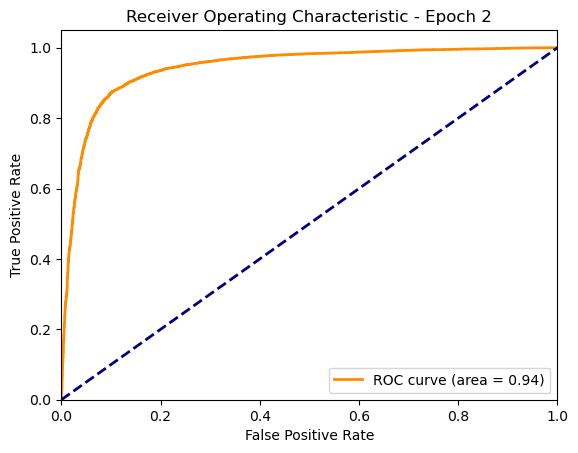

Epoch 3/25 - Training:   0%|          | 0/2795 [00:00<?, ?batch/s]

Epoch 3/25 - Evaluation:   0%|          | 0/699 [00:00<?, ?batch/s]

Epoch [3/25], Train Loss: 0.3220, Train Accuracy: 0.8774, Test Loss: 0.2990, Test Accuracy: 0.8705, Test AUC: 0.9417


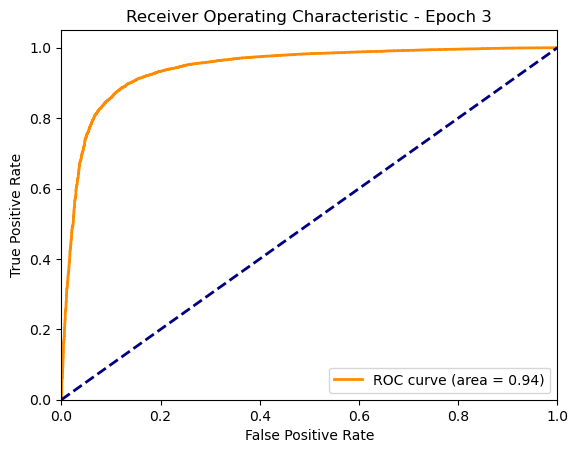

Saved new best model for epoch 3 for model densenet169


Epoch 4/25 - Training:   0%|          | 0/2795 [00:00<?, ?batch/s]

Epoch 4/25 - Evaluation:   0%|          | 0/699 [00:00<?, ?batch/s]

Epoch [4/25], Train Loss: 0.3147, Train Accuracy: 0.8799, Test Loss: 0.2823, Test Accuracy: 0.8962, Test AUC: 0.9427


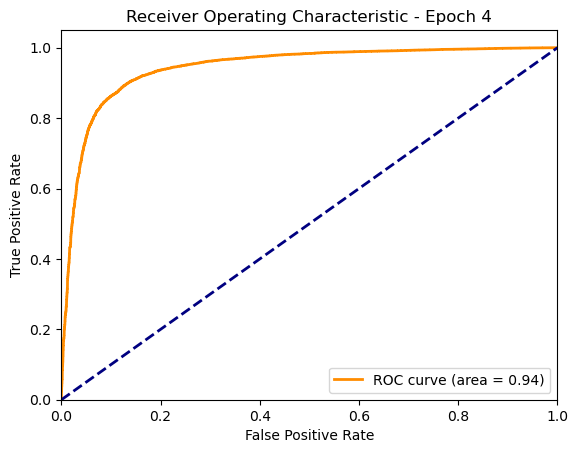

Saved new best model for epoch 4 for model densenet169


Epoch 5/25 - Training:   0%|          | 0/2795 [00:00<?, ?batch/s]

Epoch 5/25 - Evaluation:   0%|          | 0/699 [00:00<?, ?batch/s]

Epoch [5/25], Train Loss: 0.3024, Train Accuracy: 0.8857, Test Loss: 0.2966, Test Accuracy: 0.8790, Test AUC: 0.9426


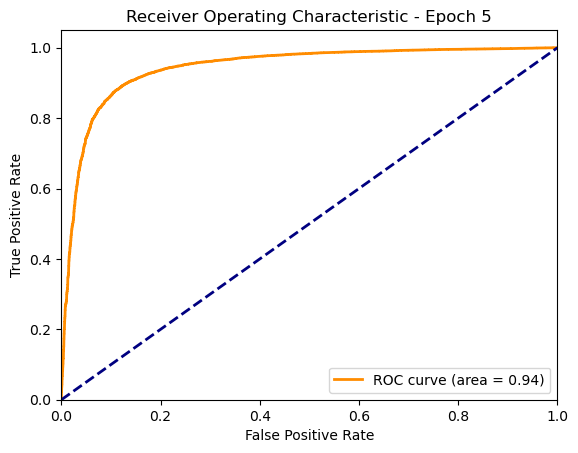

Epoch 6/25 - Training:   0%|          | 0/2795 [00:00<?, ?batch/s]

Epoch 6/25 - Evaluation:   0%|          | 0/699 [00:00<?, ?batch/s]

Epoch [6/25], Train Loss: 0.2993, Train Accuracy: 0.8862, Test Loss: 0.2961, Test Accuracy: 0.8849, Test AUC: 0.9404


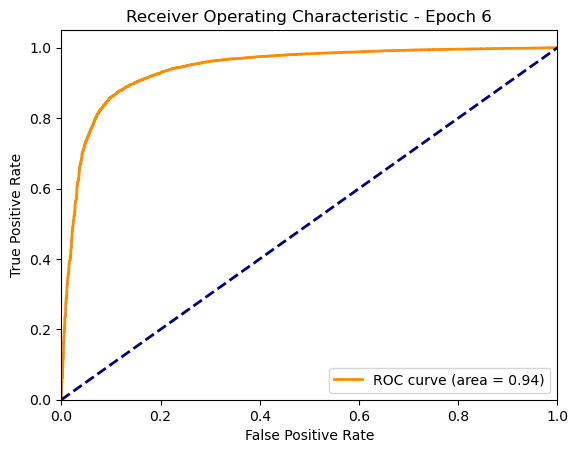

Epoch 7/25 - Training:   0%|          | 0/2795 [00:00<?, ?batch/s]

Epoch 7/25 - Evaluation:   0%|          | 0/699 [00:00<?, ?batch/s]

Epoch [7/25], Train Loss: 0.2964, Train Accuracy: 0.8882, Test Loss: 0.2798, Test Accuracy: 0.8947, Test AUC: 0.9422


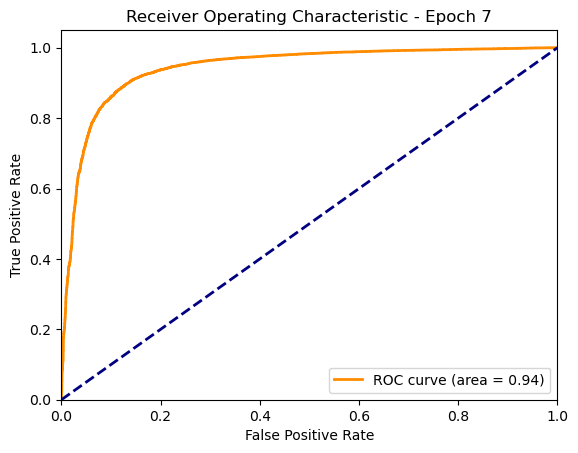

Saved new best model for epoch 7 for model densenet169


Epoch 8/25 - Training:   0%|          | 0/2795 [00:00<?, ?batch/s]

Epoch 8/25 - Evaluation:   0%|          | 0/699 [00:00<?, ?batch/s]

Epoch [8/25], Train Loss: 0.2885, Train Accuracy: 0.8912, Test Loss: 0.3302, Test Accuracy: 0.8659, Test AUC: 0.9409


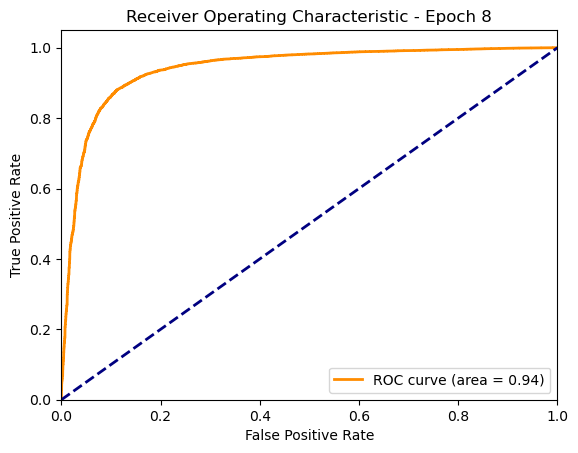

Epoch 9/25 - Training:   0%|          | 0/2795 [00:00<?, ?batch/s]

Epoch 9/25 - Evaluation:   0%|          | 0/699 [00:00<?, ?batch/s]

Epoch [9/25], Train Loss: 0.2869, Train Accuracy: 0.8907, Test Loss: 0.3084, Test Accuracy: 0.8751, Test AUC: 0.9409


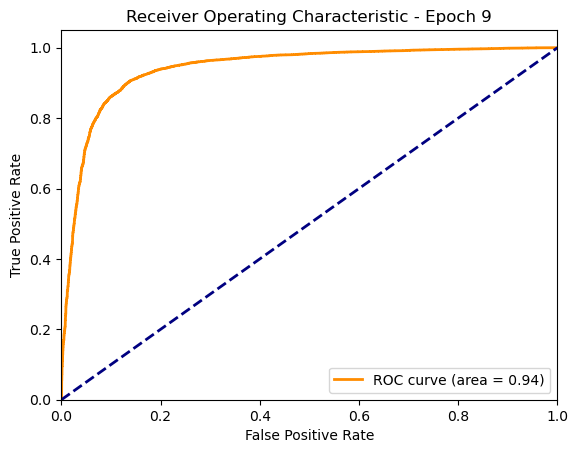

Epoch 10/25 - Training:   0%|          | 0/2795 [00:00<?, ?batch/s]

Epoch 10/25 - Evaluation:   0%|          | 0/699 [00:00<?, ?batch/s]

Epoch [10/25], Train Loss: 0.2766, Train Accuracy: 0.8954, Test Loss: 0.2905, Test Accuracy: 0.8867, Test AUC: 0.9413


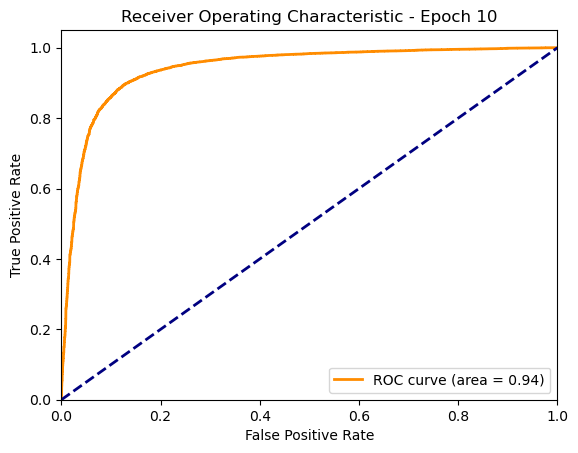

Epoch 11/25 - Training:   0%|          | 0/2795 [00:00<?, ?batch/s]

Epoch 11/25 - Evaluation:   0%|          | 0/699 [00:00<?, ?batch/s]

Epoch [11/25], Train Loss: 0.2696, Train Accuracy: 0.8974, Test Loss: 0.3149, Test Accuracy: 0.8711, Test AUC: 0.9387


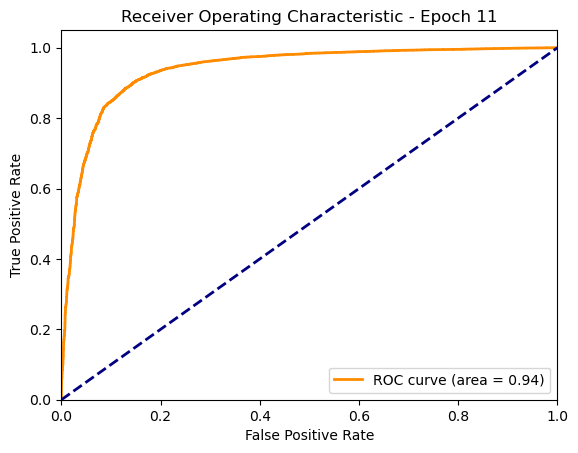

Epoch 12/25 - Training:   0%|          | 0/2795 [00:00<?, ?batch/s]

Epoch 12/25 - Evaluation:   0%|          | 0/699 [00:00<?, ?batch/s]

Epoch [12/25], Train Loss: 0.2648, Train Accuracy: 0.8991, Test Loss: 0.3515, Test Accuracy: 0.8713, Test AUC: 0.9365


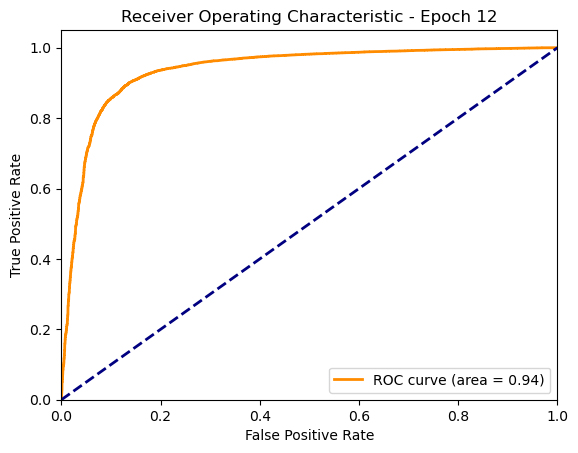

Early stopping at epoch 12 for model densenet169
Model pickled saved in finetuned_models/densenet169.pkl
Model pth saved in finetuned_models/densenet169.pth
Model saved as onnx in finetuned_models/densenet169.onnx
Epoch 1, Last Learning Rate: 0.0001
Epoch 2, Last Learning Rate: 0.0001
Epoch 3, Last Learning Rate: 0.0001
Epoch 4, Last Learning Rate: 0.0001
Epoch 5, Last Learning Rate: 0.0001
Epoch 6, Last Learning Rate: 0.0001
Epoch 7, Last Learning Rate: 1e-05
Epoch 8, Last Learning Rate: 1e-05
Epoch 9, Last Learning Rate: 1e-05
Epoch 10, Last Learning Rate: 1e-05
Epoch 11, Last Learning Rate: 1e-05
Epoch 12, Last Learning Rate: 1e-05
Epoch 13, Last Learning Rate: 1.0000000000000002e-06
Epoch 14, Last Learning Rate: 1.0000000000000002e-06
Epoch 15, Last Learning Rate: 1.0000000000000002e-06
Epoch 16, Last Learning Rate: 1.0000000000000002e-06
Epoch 17, Last Learning Rate: 1.0000000000000002e-06
Epoch 18, Last Learning Rate: 1.0000000000000002e-06
Epoch 19, Last Learning Rate: 1.0000000

In [ ]:
# Define the loss function
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer with weight decay
# AdamW optimizer with a learning rate of 0.0001 and weight decay of 1e-5
optimizer_densenet = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Define a learning rate scheduler
# ReduceLROnPlateau reduces the learning rate when a metric has stopped improving
scheduler = ReduceLROnPlateau(optimizer_densenet, mode='min', factor=0.1, patience=5)

# Define the number of epochs
num_epochs = 25

# Train the model
# Parameters:
# - model: The model to be trained (DenseNet169 in this case)
# - train_loader: DataLoader for the training dataset
# - test_loader: DataLoader for the validation dataset
# - criterion: The loss function
# - optimizer: The optimizer
# - scheduler: The learning rate scheduler
# - num_epochs: Number of epochs to train the model
# - device: Device to train the model on ('cpu' or 'cuda')
# - model_name: Filename to save the trained model
# - num_workers: Number of worker processes for data loading
train_losses, train_accuracies, test_losses, test_accuracies, test_aucs = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=validation_loader,
    criterion=criterion,
    optimizer=optimizer_densenet,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device,
    model_name=model_name,
    num_workers=1
)

# Adjust the learning rate based on the validation loss
for epoch in range(num_epochs):
    # Adjust the learning rate based on the latest validation loss
    scheduler.step(test_losses[-1])
    # Get and print the last learning rate
    last_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch + 1}, Last Learning Rate: {last_lr}")

### Evaluate the trained model on test dataset

C:\Users\bar24\AppData\Local\Temp\ipykernel_46696\3047285912.py:431: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(path, map_location=device)


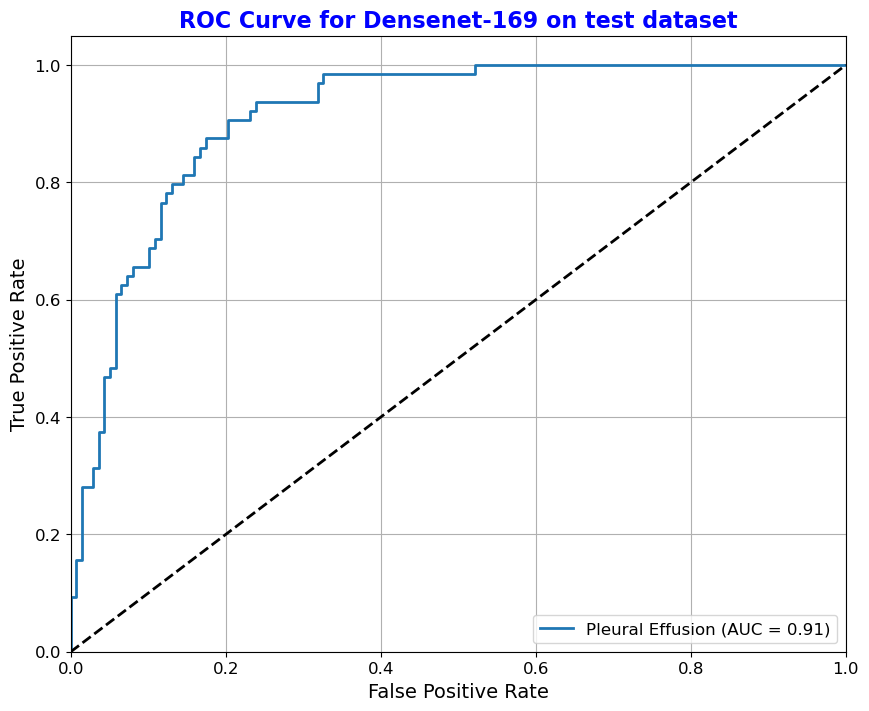

In [ ]:
test_preds, test_labels = predict_model(model, test_loader, device)
# Plot ROC curve for the test dataset
plot_roc_curve(test_labels, test_preds, model_name=model_name)

In [25]:
# if we runnign on colab upload finetuned_models folder to drive as zip
# Assuming 'finetuned_models' is in the current directory.
# Adjust the path if necessary.

if is_colab():
    folder_to_zip = 'finetuned_models'
    zip_file_name = 'finetuned_models.zip'

    # Create a zip archive of the 'finetuned_models' folder
    with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_to_zip):
            for file in files:
                zipf.write(os.path.join(root, file),
                        os.path.relpath(os.path.join(root, file),
                                        os.path.join(folder_to_zip, '..')))

    # Upload the zip file to Google Drive
    from google.colab import files
    files.download(zip_file_name)
else: 
    print("Not in Google Colab.")

Not in Google Colab.


# Generating and Evaluating Explanations

## Load trained model

In [20]:
model_name = "densenet169"

if model_name == "densenet169":
    model = upload_pretrained_densenet169(add_layers=True, n_labels=len(class_names), freeze_layers=False, modify_first_layer=modify_first_layer)

elif model_name == "densenet201":
    model = upload_pretrained_densenet201(add_layers=True, n_labels=len(class_names), freeze_layers=True, modify_first_layer=modify_first_layer)

else:
    print("Model not found.")

if model is not None:
    state_dict = torch.load(f"finetuned_models/{model_name}.pth", map_location=device, weights_only=False)
    model.load_state_dict(state_dict)
    print(f"Model {model_name} was loaded successfully.")

Model densenet169 was loaded successfully.


## 1st part: Visualisation of gradcam with ground truth bounding boxes

### Global definiotns for this part and reading of ground trough data

In [21]:
# Define the transformation pipeline for the images
transform = get_transform()

# Ground truth data reading
# reading based on where the data are stored
path = "ground_truth_data/bbox320x320.xlsx" # change this to the path of the ground truth data
if is_colab():
    path = "/content/drive/MyDrive/UU/ground_truth_data/bbox320x320.xlsx" # "ground_truth_data/bbox320x320.xlsx" # change this to the path of the ground truth data
ground_truth_df = pd.read_excel(path)
ground_truth_df.head()

Image   x_start  y_start   x_end   y_end  x_start.1  y_start .1  x_end .1  \
0   Test        48       160     144    288        NaN         NaN       NaN   
1  Rad_1       176       128     288    256        NaN         NaN       NaN   
2   Rad_2       32       128     144    256        NaN         NaN       NaN   
3  Rad_3        32       144     144    288      176.0       144.0     288.0   
4  Rad_5        32       160     144    240        NaN         NaN       NaN   

   y_end.1  
0      NaN  
1      NaN  
2      NaN  
3    272.0  
4      NaN

In [22]:
# Read ground truth images
images_paths = []
attributes_list = []

prefix_path = "./"
if is_colab():
    prefix_path = "/content/drive/MyDrive/UU/"

# Looping through ground truth DataFrame to get/construct paths of images except Test's image 
images_paths = []
attributes_list = []

all_images_paths = []
all_attributes_list = []

for row, column in ground_truth_df.iterrows():
    if column['Image '] == "Test ":
        all_images_paths.append(f"ranking_annotations/test_image.png")
        all_attributes_list.append(column[['Image ', 'x_start', 'y_start ', 'x_end ', 'y_end']])
    else:
        path = f"ground_truth_images/{column['Image '].strip()}.png"
        all_images_paths.append(path)
        images_paths.append(path)
        attributes_list.append(column[['Image ', 'x_start', 'y_start ', 'x_end ', 'y_end']])
        all_attributes_list.append(column[['Image ', 'x_start', 'y_start ', 'x_end ', 'y_end']])

labels = np.array([1, 1, 1, 1])

ground_truth_images_df = pd.DataFrame({"path": images_paths, "Pleural Effusion": labels})
ground_truth_images_df.head()

path  Pleural Effusion
0  ground_truth_images/Rad_1.png                 1
1  ground_truth_images/Rad_2.png                 1
2  ground_truth_images/Rad_3.png                 1
3  ground_truth_images/Rad_5.png                 1

## Utils functions for evaluations

In [68]:
def evaluate_model(model, test_loader: DataLoader, criterion, device='cuda'):
    """
    Evaluate a trained PyTorch model on a test dataset.

    Parameters:
    - model: The trained PyTorch model.
    - test_loader: DataLoader for the test dataset.
    - criterion: The loss function used during training.
    - device: Device to evaluate the model on ('cpu' or 'cuda').

    Returns:
    - test_loss: Average loss on the test dataset.
    - test_accuracy: Overall accuracy on the test dataset.
    - all_predictions: List of predicted values for all samples.
    - all_labels: List of ground-truth labels for all samples.
    """
    model.to(device) # Ensure the model is on the correct device
    model.eval()  # Set the model to evaluation mode

    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the correct device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Convert outputs to binary predictions (multi-label classification)
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            # Store predictions and labels
            all_predictions.append(predicted.cpu())
            all_labels.append(labels.cpu())

            correct += (predicted == labels).sum().item()
            total += labels.numel() # Total elements (samples × labels)

    test_loss /= len(test_loader)
    test_accuracy = correct / total

    # Convert predictions and labels to tensors
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return test_loss, test_accuracy, all_predictions, all_labels


def apply_gradcam(model, image_path, transform, target_layer=None):
    """
    Apply Grad-CAM to the specified image using the provided model.

    Args:
        model: The trained model.
        image_path: Path to the image for visualization.
        transform: Image transformation pipeline.
        target_layer: The target convolutional layer for Grad-CAM. If None, uses a default layer.

    Returns:
        Tuple of (resized original image, overlayed image).
    """
    # Ensure the model is in evaluation mode and gradients are enabled
    model.eval()
    for param in model.parameters():
        param.requires_grad = True

    # Load the image and get the original image (without resizing)
    img = Image.open(image_path).convert("RGB")
    original_img = np.array(img, dtype=np.float32) / 255.0  # Original resolution
    
    # Preprocess the image (this resizes the image to the size expected by the model)
    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # If no target layer specified, choose the last conv layer in denseblock4
    if target_layer is None:
        try:
            # Using the last convolution from denselayer32 in denseblock4
            target_layer = [model.features.denseblock4.denselayer32.conv2]
        except AttributeError:
            # Fallback: use an alternative convolutional layer
            return "Not possible to extract the required convolutional layer due to missing attribute."

    # Create GradCAM object
    # cam = GradCAM(model=model, target_layers=target_layer)
    cam = GradCAMPlusPlus(model=model, target_layers=target_layer)

    # Define the target category for Grad-CAM
    targets = [ClassifierOutputTarget(0)]

    # Generate Grad-CAM heatmap (this triggers the backward pass)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Resize the original image to match the Grad-CAM output dimensions if needed
    if original_img.shape[:2] != grayscale_cam.shape:
        original_img_resized = cv2.resize(original_img, (grayscale_cam.shape[1], grayscale_cam.shape[0]))
    else:
        original_img_resized = original_img

    # Overlay the heatmap on the resized original image
    overlay = show_cam_on_image(original_img_resized, grayscale_cam, use_rgb=True)

    return original_img_resized, overlay

def visualize_gradcam_with_bbox(model, ground_truth_images_df, ground_truth_df, transform, display_only_effusion=True):
    """
    Visualize GradCAM heatmaps with bounding boxes for medical images in a 2x5 grid with gray images on top and heatmaps on the bottom.
    
    Parameters:
    -----------
    model : torch.nn.Module
        The trained model (DenseNet169) for which to compute GradCAM
    ground_truth_images_df : pandas.DataFrame
        DataFrame containing image paths and labels
    ground_truth_df : pandas.DataFrame
        DataFrame containing bounding box coordinates
    transform : torchvision.transforms
        Image transformations to apply
    display_only_effusion : bool, default=True
        If True, only process images with effusion (label == 1)
    """    
    # Set up the plot grid (2 rows, 5 columns)
    num_images = min(10, ground_truth_images_df.shape[0])  # Limit to 10 images for the 2x5 grid
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    
    axes = axes.flatten()  # Flatten the axes to easily index them
    
    image_idx = 0  # Counter for the image to plot
    for i in range(ground_truth_images_df.shape[0]):
        image_path = ground_truth_images_df.iloc[i]['path']
        actual_label = ground_truth_images_df.iloc[i]["Pleural Effusion"]
        print('Label:',actual_label)
        # Load BBOX coordinates
        x_start, y_start, x_end, y_end, x_start_, y_start_, x_end_, y_end_ = ground_truth_df.iloc[i][
            ['x_start', 'y_start ', 'x_end ', 'y_end', 'x_start.1', 'y_start .1', 'x_end .1', 'y_end.1']
        ]
        pattern = r'([^/\\]+)(?=\.png)'
        # Extract filenames using regex
        extracted_files = re.findall(pattern, image_path)
        print(f"Image Path: {extracted_files}")
        
        # Skip non-effusion images if display_only_effusion is True
        if display_only_effusion and actual_label != 1:
            continue
        
        # Apply GradCAM
        original_img, overlay = apply_gradcam(
            model=model,
            image_path=image_path,
            transform=transform,
        )

        original_img *= (1.0/original_img.max())
        
        # Scale BBOX coordinates to 224x224
        original_width, original_height = Image.open(image_path).size
        scale_x = 224 / original_width
        scale_y = 224 / original_height
        
        x_start_rescaled = int(x_start * scale_x)
        y_start_rescaled = int(y_start * scale_y)
        x_end_rescaled = int(x_end * scale_x)
        y_end_rescaled = int(y_end * scale_y)
        
        # Optional handling for second bounding box if needed
        has_second_bbox = all(pd.notna(val) for val in [x_start_, y_start_, x_end_, y_end_])
        
        if has_second_bbox:
            x_start_rescaled_ = int(x_start_ * scale_x)
            y_start_rescaled_ = int(y_start_ * scale_y)
            x_end_rescaled_ = int(x_end_ * scale_x)
            y_end_rescaled_ = int(y_end_ * scale_y)
        
        # Draw primary BBOX on Original Image
        img_with_bbox = original_img.copy()
        cv2.rectangle(img_with_bbox,
                      (x_start_rescaled, y_start_rescaled),
                      (x_end_rescaled, y_end_rescaled),
                      color=(255, 255, 255),
                      thickness=1)
        
        # Draw primary BBOX on Grad-CAM Overlay
        overlay_with_bbox = overlay.copy()
        cv2.rectangle(overlay_with_bbox,
                      (x_start_rescaled, y_start_rescaled),
                      (x_end_rescaled, y_end_rescaled),
                      color=(255, 255, 255),
                      thickness=1)
        
        # Draw second BBOX if it exists
        if has_second_bbox:
            cv2.rectangle(img_with_bbox,
                          (x_start_rescaled_, y_start_rescaled_),
                          (x_end_rescaled_, y_end_rescaled_),
                          color=(0, 255, 0),  # Using green color for the second bbox
                          thickness=1)
            
            cv2.rectangle(overlay_with_bbox,
                          (x_start_rescaled_, y_start_rescaled_),
                          (x_end_rescaled_, y_end_rescaled_),
                          color=(0, 255, 0),  # Using green color for the second bbox
                          thickness=1)
        
        # Plot Images in 2x5 grid with gray images on top and heatmaps on the bottom
        if image_idx < num_images:  # Ensure not to exceed the 10-image limit
            # normlize image 
            # img_with_bbox *= (1.0/img_with_bbox.max())
            img_with_bbox = np.clip(img_with_bbox, 0, 1)


            # Top row (Original Image with Bounding Box)
            ax = axes[image_idx]
            ax.imshow(img_with_bbox)
            ax.set_title(f"Original Image {extracted_files[0]}")
            ax.axis("off")
        
            # Bottom row (Grad-CAM Heatmap with Bounding Box)
            ax = axes[image_idx+5]  # Offset by 5 for the bottom row
            ax.imshow(overlay_with_bbox)
            ax.set_title(f"Grad-CAM Heatmap {extracted_files[0]}")
            ax.axis("off")
        
            image_idx += 1  # Move to the next image index

    # Adjust layout
    plt.tight_layout()
    plt.show()

#### Utils functions for metric

In [69]:
def generate_saliency_map_(model, inputs, **kwargs):
    """
    Generate a saliency map using Grad-CAM for the given model and inputs.

    Args:
        model: The model to generate the saliency map for.
        inputs: Input tensor or numpy array.
        **kwargs: Additional arguments.

    Returns:
        saliency_maps: The generated saliency maps.
    """
    model.eval()
    
    # Ensure tensor is on the correct device and requires gradients
    device = next(model.parameters()).device  
    
    if isinstance(inputs, np.ndarray):
        inputs = torch.from_numpy(inputs).float()
    
    inputs = inputs.to(device)  # Ensure the tensor is on the correct device
    
    # Make sure input has batch dimension
    if len(inputs.shape) == 3:  # If [channels, height, width]
        inputs = inputs.unsqueeze(0)  # Add batch dimension [1, channels, height, width]
    
    # Try to get the appropriate target layer
    try:
        target_layers = [model.model.features.denseblock4.denselayer32.conv2]  # Your original layer
    except AttributeError:
        try:
            target_layers = [model.features.denseblock4.denselayer32.conv2]  # Alternative layer path
        except AttributeError:
            raise ValueError("Please specify a valid target layer for your model architecture")
    
    targets = [ClassifierOutputTarget(0)]  
    
    # Use GradCAM to calculate the saliency map
    # cam = GradCAM(model=model, target_layers=target_layers)
    cam = GradCAMPlusPlus(model=model, target_layers=target_layers)
    saliency_maps = cam(input_tensor=inputs, targets=targets)
    
    # Ensure the saliency maps are non-zero
    # saliency_maps = np.clip(saliency_maps, 1e-8, None)
    
    return saliency_maps


def apply_gradcam_batch(model, images, target_layer=None):
    """
    Apply GradCAM to a batch of input images.

    Args:
        model: The model to generate explanations for.
        images: Batch of images as tensor [batch_size, channels, height, width].
        target_layer: Target layer for GradCAM.

    Returns:
        Dictionary with original images, GradCAM heatmaps, overlays, and predictions.
    """
    model.eval()
    device = next(model.parameters()).device

    if images.device != device:
        images = images.to(device)

    batch_size, channels, height, width = images.shape

    with torch.no_grad():
        outputs = model(images)
        predicted_classes = (torch.sigmoid(outputs) > 0.5).long().squeeze()

    if target_layer is None:
        try:
            target_layer = [model.features.denseblock4.denselayer32.conv2]
        except AttributeError:
            raise ValueError("Specify a valid target_layer for your model architecture.")

    # cam = GradCAM(model=model, target_layers=target_layer)
    cam = GradCAMPlusPlus(model=model, target_layers=target_layer)

    results = {
        "original_images": [],
        "grayscale_cams": [],
        "overlays": [],
        "predicted_classes": predicted_classes.cpu().numpy()
    }

    for i in range(batch_size):
        input_tensor = images[i:i+1]

        targets = [ClassifierOutputTarget(0)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

        original_img = images[i].cpu().numpy()

        results["original_images"].append(original_img)
        results["grayscale_cams"].append(grayscale_cam)

    results["original_images"] = np.stack(results["original_images"], axis=0)
    results["grayscale_cams"] = np.stack(results["grayscale_cams"], axis=0)

    return results


class WrappedModel(nn.Module):
    """
    A wrapper class for a model to modify its output for binary classification.
    """
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x):
        """
        Forward pass for the wrapped model.

        Args:
            x: Input tensor.

        Returns:
            probs: Tensor with two-class probabilities [1 - p, p].
        """
        outputs = self.model(x)  # shape: (N, 1) for binary classification
        p = torch.sigmoid(outputs)  # Apply sigmoid to get probability for the positive class
        probs = torch.cat([1 - p, p], dim=1)  # Create two-class probabilities: [1 - p, p]
        return probs

def dcg_calculation(df_ranking):
    """
    Calculate the nDCG score for the ranked images.

    Parameters:
    -----------
    df_ranking : dataframe of the ranked images with their relevance scores

    Returns:
    --------
    Float : nDCG score
    """
    # Relevance scores in ideal order
    true_relevance = np.arange(1, 11).reshape(1, -1)

    # Relevance scores in output order by retrieving the order from cosine similarity dictionary
    # output_order = [int(re.search(r'Rad_(\d+)', entry[0]).group(1)) for entry in sorted_ranking_dict]
    output_order = df_ranking['Original Ranking'].values
    # relevance_score = np.zeros_like(output_order)
    relevance_score = np.asarray([output_order])
    score =  ndcg_score(true_relevance, relevance_score)

    print(f"nDCG score: {score:.4f}")
    return score




class GroundTruthDataset(Dataset):
    """
    A custom dataset class for loading ground truth images and labels.
    """
    def __init__(self, df, transform=None):
        """
        Initialize the dataset.

        Args:
            df: DataFrame containing image paths and labels.
            transform: Image transformations to apply.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        """
        Return the length of the dataset.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Get an item from the dataset.

        Args:
            idx: Index of the item.

        Returns:
            image: Transformed image.
            label: Corresponding label.
        """
        img_path = self.df.iloc[idx]["path"]
        label = self.df.iloc[idx]["Pleural Effusion"]
        
        # Open Image
        image = Image.open(img_path)
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

In [70]:
# Gloabl variables for this part

# Create the wrapped model
wrapped_model = WrappedModel(model)
wrapped_model.eval()

# Define Ground Truth images and labels
all_labels = np.array([1, 1, 1, 1, 1])
all_ground_truth_images = pd.DataFrame({"path": all_images_paths, "Pleural Effusion": all_labels})

# Create dataset and dataloader
ground_truth_dataset = GroundTruthDataset(all_ground_truth_images, transform=transform)
ground_truth_loader = DataLoader(ground_truth_dataset, batch_size=5, shuffle=False)

# Extract one batch
test_images, test_labels = next(iter(ground_truth_loader))

# Apply GradCAM to the batch of images
result_gradcam = apply_gradcam_batch(model, images=test_images)

# Extract results
x_batch, y_batch, a_batch = result_gradcam['original_images'], result_gradcam['predicted_classes'], result_gradcam['grayscale_cams']

C:\Users\bar24\AppData\Roaming\Python\Python312\site-packages\albumentations\core\transforms_interface.py:200: UserWarning: The image is already gray.
  target_function(ensure_contiguous_output(arg), **params),


In [26]:
# calculate loss, accuracy, predictions, and labels of test dataset
criterion = nn.BCEWithLogitsLoss()
test_loss, test_accuracy, predictions, true_labels = evaluate_model(model, test_loader, criterion, device=device)

Evaluating:   0%|          | 0/7 [00:00<?, ?batch/s]

Test Loss: 0.3994, Test Accuracy: 0.8366


Label: 1
Image Path: ['test_image']
Label: 1
Image Path: ['Rad_1']
Label: 1
Image Path: ['Rad_2']
Label: 1
Image Path: ['Rad_3']
Label: 1
Image Path: ['Rad_5']


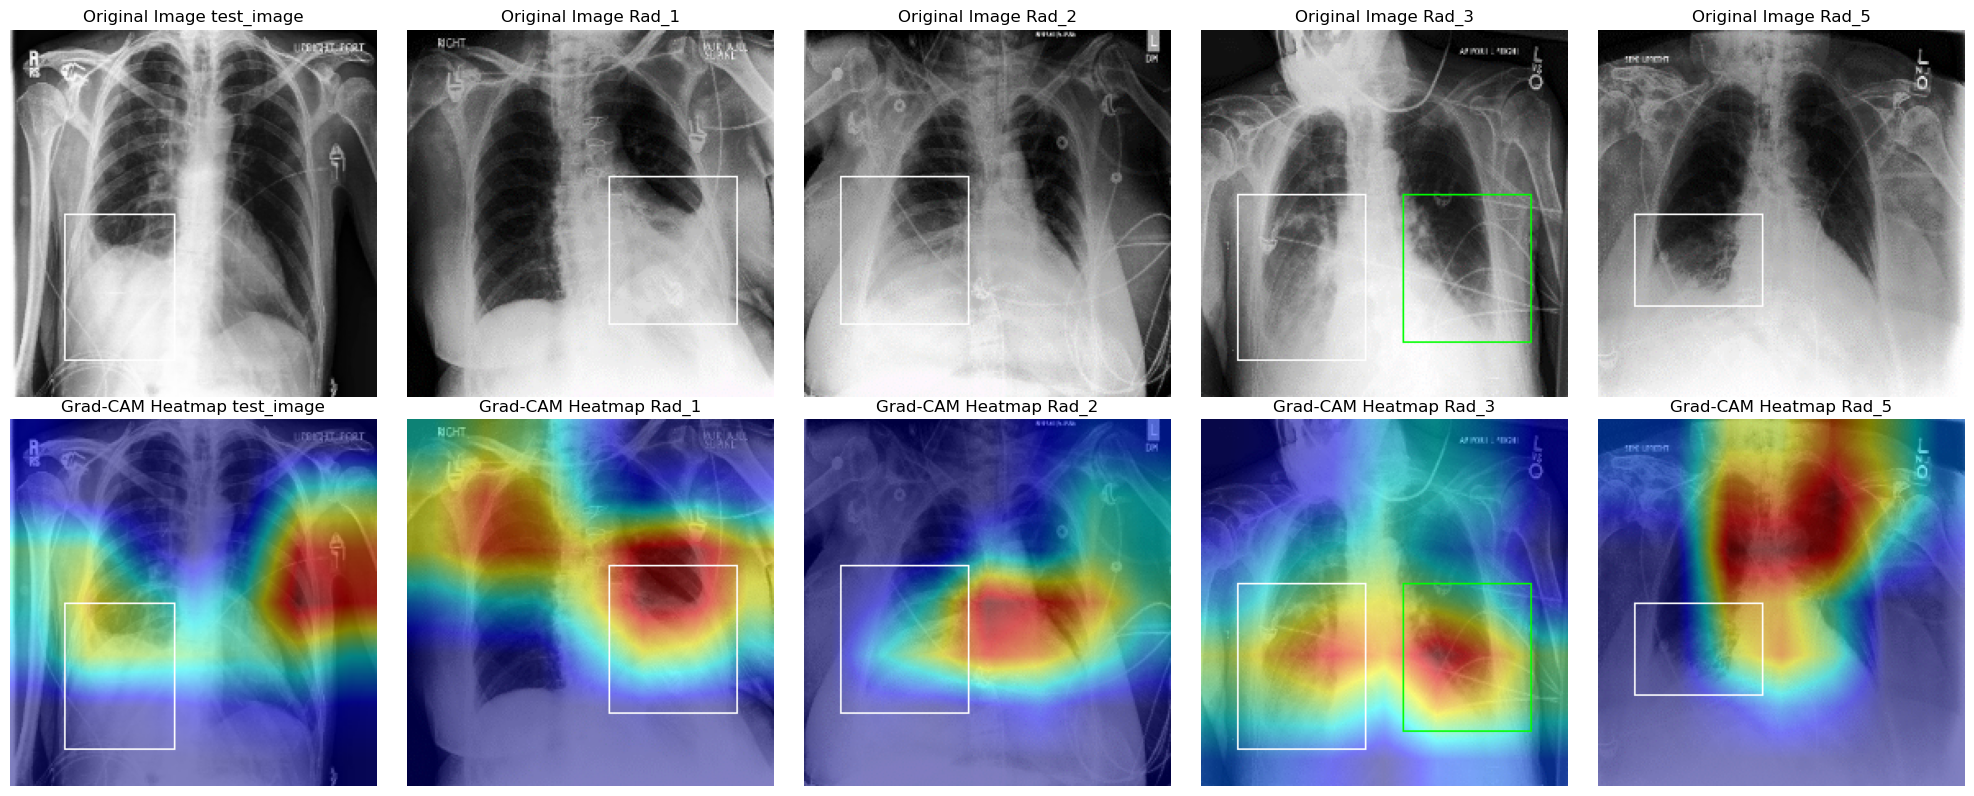

In [71]:
# Visualize GradCAM heatmaps with bounding boxes for images that we were given bounding boxes for
visualize_gradcam_with_bbox(
    model=model,
    ground_truth_images_df=all_ground_truth_images,
    ground_truth_df=ground_truth_df,
    transform=transform
)

### Evaluate Using Grad-CAM on the Test Dataset

In [29]:
test_predicts, test_labels = predict_model(model, test_loader, device)
test_labels = test_labels.astype(int).squeeze()
test_df_filtered = test_df[test_df['Pleural Effusion'] == 1]

# Get the indexes of the filtered DataFrame
filtered_indexes = test_df_filtered.index

# Filter test_predicts and test_labels using the filtered indexes
test_predicts_filtered = test_predicts[filtered_indexes]
test_labels_filtered = test_labels[filtered_indexes]

print(f"there are {test_df_filtered.shape[0]} images with Pleural Effusion")

there are 64 images with Pleural Effusion


Actual label: 1 and Predicted label: 1


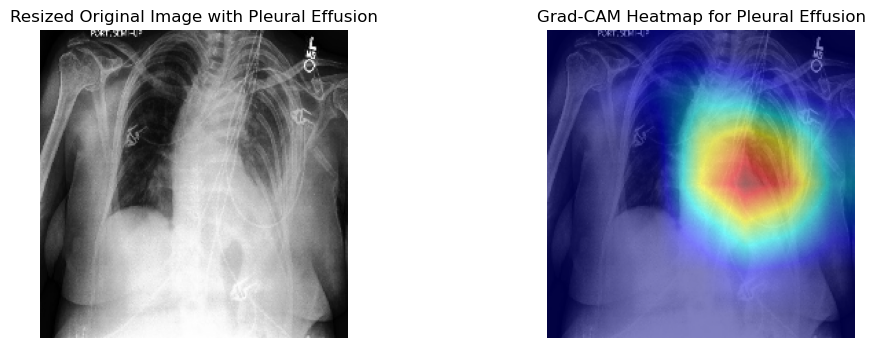

Actual label: 1 and Predicted label: 1


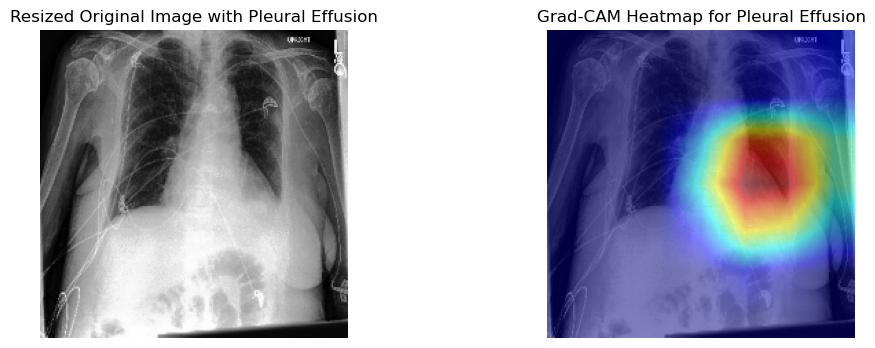

Actual label: 1 and Predicted label: 1


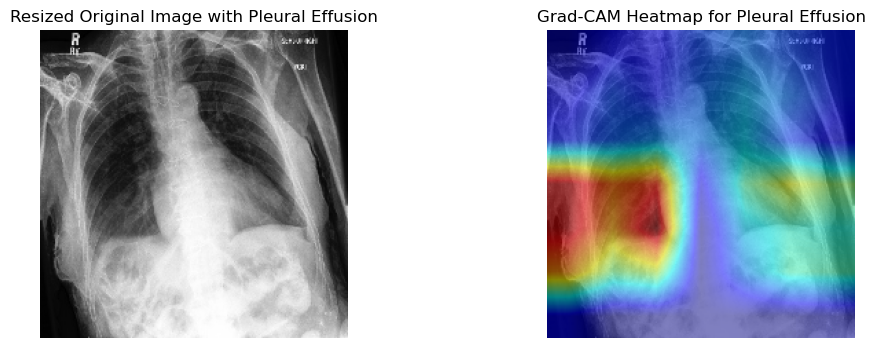

Actual label: 1 and Predicted label: 1


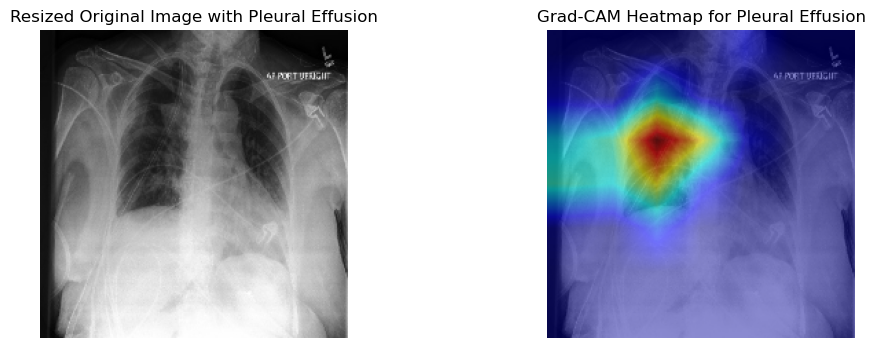

Actual label: 1 and Predicted label: 1


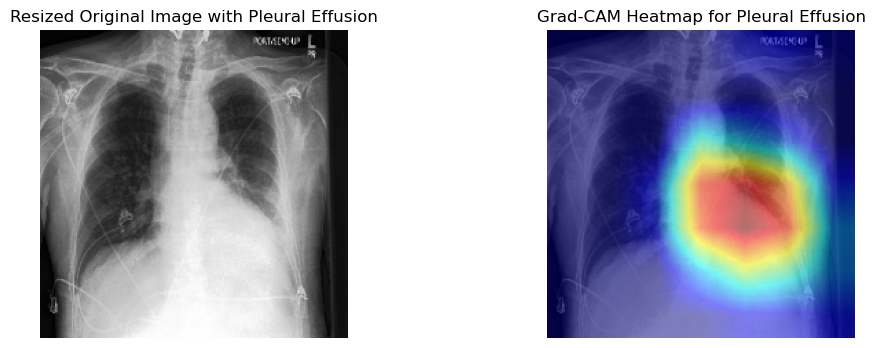

In [72]:
# Evaluate using Grad-CAM on random images from the test dataset
num_images = 5  # Number of random images to select
random_indices = random.sample(range(len(test_df_filtered)), num_images)

for i in random_indices:
    image_path = test_df_filtered.iloc[i]['path']
    actual_label = test_df_filtered.iloc[i]["Pleural Effusion"]
    predicted_label = test_labels_filtered[i]

    print(f"Actual label: {actual_label} and Predicted label: {predicted_label}")
    original_img, overlay = apply_gradcam(
        model=model,
        image_path=image_path,
        transform=transform,
    )

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Resized Original Image with Pleural Effusion")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap for Pleural Effusion")
    plt.axis("off")

    plt.show()

## 2nd Part: Example-based explanation

### In this example, we do it based on ground_truth_images_df, first function is a class that extract features from specific layers
https://www.digitalocean.com/community/tutorials/pytorch-hooks-gradient-clipping-debugging#the-forward-hook-for-visualising-activations


In [73]:
class FeatureExtractor:
    def __init__(self, model):
        self.model = model
        self.model.eval()  # Set model to evaluation mode
        self.activations = dict()  # Store activations per sample and then .clear() it

    def hook_fn(self, module, input, output):
        self.activations['output'] = output  # Store feature map

    def get_embeddings(self, image_paths, transform):
        embeddings = []

        # Register hook
        hook_handle = self.model.features.register_forward_hook(self.hook_fn)

        with torch.no_grad():  # Prevents tracking gradients
            for idx, path in enumerate(image_paths):
                # Load and preprocess image
                image = Image.open(path).convert("RGB") # convert to grayscale # .convert('RGB')
                image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

                # Move the image tensor to the same device as the model
                image_tensor = image_tensor.to(next(self.model.parameters()).device)

                # Clear previous activations
                self.activations.clear()

                # Forward pass
                _ = self.model(image_tensor)

                # Retrieve hooked feature maps
                features = self.activations['output']

                # Apply ReLU activation
                features = F.relu(features, inplace=True)

                # Global average pooling
                pooled_features = F.adaptive_avg_pool2d(features, (1, 1))

                # Flatten into a 1D vector
                embedding = torch.flatten(pooled_features, 1)

                # Append to list after detaching from computation graph
                embeddings.append(embedding.detach().cpu())

        # Remove hook
        hook_handle.remove()

        return torch.cat(embeddings, dim=0)  # Combine all embeddings into one tensor

### Extraction and Similarity Analysis of the Most Similar Images Based on the Provided Test Image

In [74]:
# Define the folder path
folder = prefix_path + "ranking_annotations"

# Get image paths for ranking and testing
ranking_image_paths = [
    os.path.join(folder, file)
    for file in os.listdir(folder) if file.startswith("Rad")
]

testing_image_path = [
    os.path.join(folder, file)
    for file in os.listdir(folder) if file.startswith("test")
]

# Create feature extractor
extractor = FeatureExtractor(model)

# Extract embeddings
embeddings_torank = extractor.get_embeddings(image_paths=ranking_image_paths, transform=transform)
embeddings_test = extractor.get_embeddings(image_paths=testing_image_path, transform=transform)

# Calculate similarity scores and rank images
ranking_dict = {}
for idx, embedding_torank in enumerate(embeddings_torank):
    similarity_score = F.cosine_similarity(embedding_torank, embeddings_test)
    ranking_dict[ranking_image_paths[idx]] = float(similarity_score)

df_ranking = pd.DataFrame(ranking_dict.items(), columns=['Image', 'Similarity Score'])
df_ranking = df_ranking.sort_values(by='Similarity Score', ascending=False).reset_index(drop=True)
# Extract the original rank from the Image column
df_ranking['Original Ranking'] = df_ranking['Image'].apply(lambda x: int(re.search(r'Rad_(\d+)', x).group(1)))

# Add the New Rank column dynamically
num_rows = len(df_ranking)
df_ranking['New Ranking'] = 1.0 + 0.5 * (num_rows - 1 - df_ranking.index)

# Display the top 10 ranked images
display(df_ranking)


# Calculate the nDCG score
dcg_score = dcg_calculation(df_ranking)

Image  Similarity Score  Original Ranking  \
0   ./ranking_annotations\Rad_3.png          0.927573                 3   
1   ./ranking_annotations\Rad_4.png          0.915187                 4   
2   ./ranking_annotations\Rad_1.png          0.897443                 1   
3   ./ranking_annotations\Rad_2.png          0.877093                 2   
4   ./ranking_annotations\Rad_6.png          0.859572                 6   
5   ./ranking_annotations\Rad_5.png          0.803502                 5   
6   ./ranking_annotations\Rad_8.png          0.664204                 8   
7   ./ranking_annotations\Rad_7.png          0.376955                 7   
8  ./ranking_annotations\Rad_10.png          0.283719                10   
9   ./ranking_annotations\Rad_9.png          0.249885                 9   

   New Ranking  
0          5.5  
1          5.0  
2          4.5  
3          4.0  
4          3.5  
5          3.0  
6          2.5  
7          2.0  
8          1.5  
9          1.0

nDCG score: 0.9804


### Gradcam on sorted by similarity samples

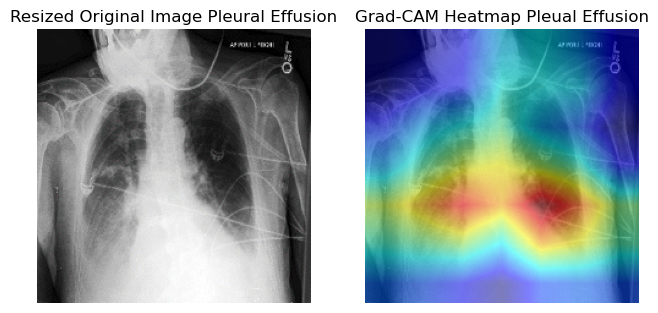

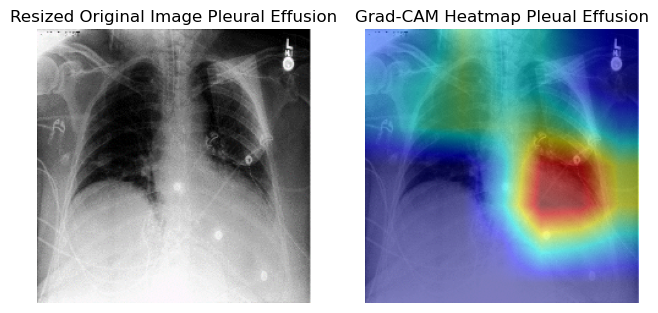

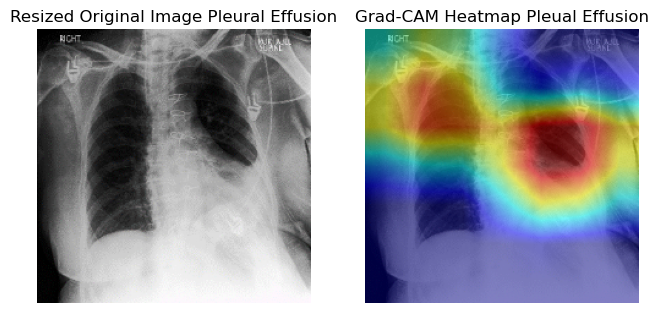

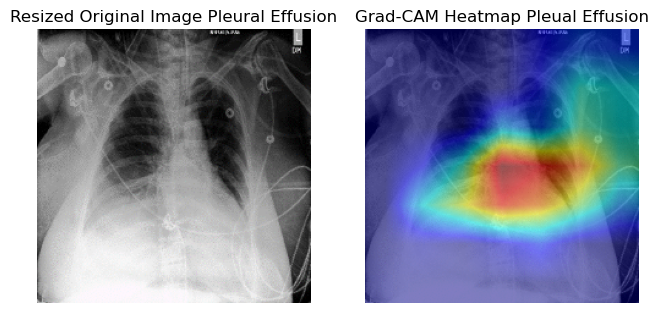

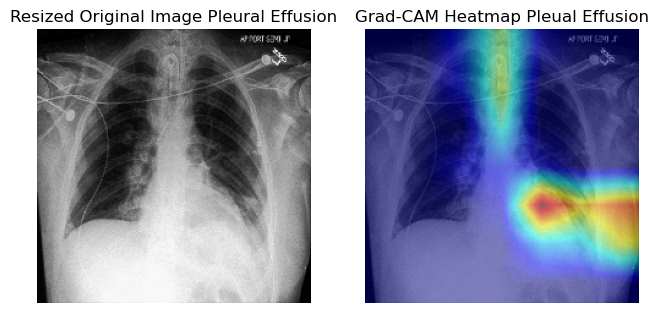

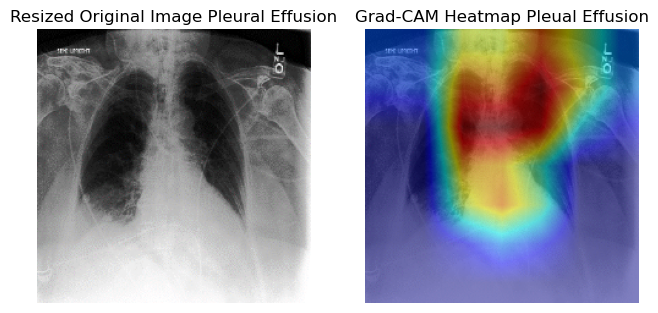

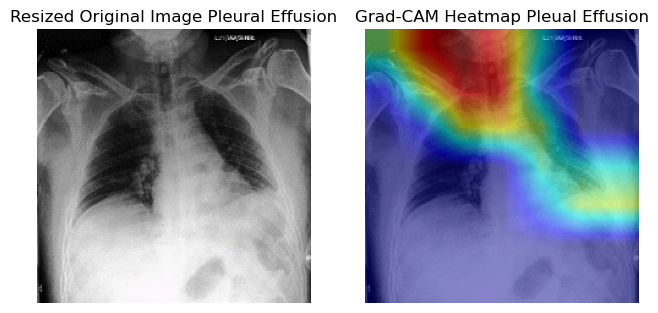

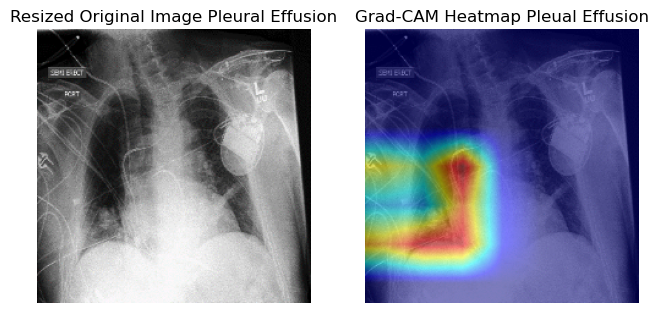

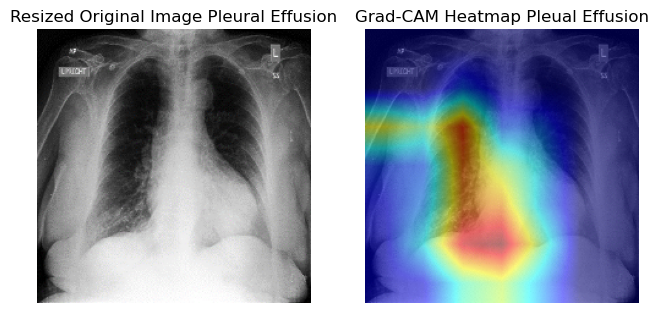

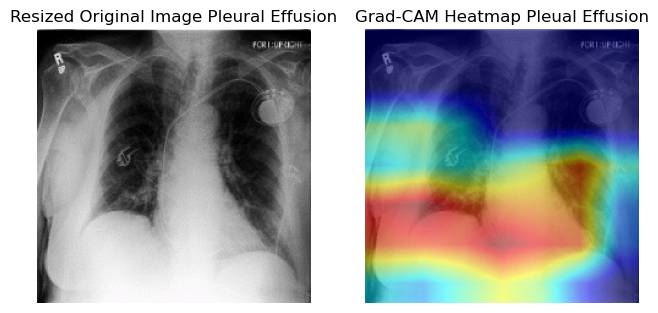

In [75]:
for index, row in df_ranking.iterrows():
    image_path = row['Image']

    original_img, overlay = apply_gradcam(
            model=model,
            image_path=image_path,
            transform=transform)


    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Resized Original Image Pleural Effusion")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap Pleual Effusion")
    plt.axis("off")


    plt.show()

### Metrics

### Robustness: local Lipschitz estimate (Alvarez-Melis et al., 2018) 

In [76]:
# Define the Local Lipschitz Estimate metric for robustness evaluation
metric_robustness = quantus.LocalLipschitzEstimate(
    nr_samples=15,  # Number of samples to estimate the Lipschitz constant
    perturb_std=0.4,  # Standard deviation of the Gaussian noise for perturbation
    perturb_mean=0.0,  # Mean of the Gaussian noise for perturbation
    norm_numerator=quantus.similarity_func.distance_euclidean,  # Function to compute the distance in the numerator
    norm_denominator=quantus.similarity_func.distance_euclidean,  # Function to compute the distance in the denominator
    perturb_func=quantus.perturb_func.gaussian_noise,  # Function to apply Gaussian noise for perturbation
    similarity_func=quantus.similarity_func.lipschitz_constant  # Function to compute the Lipschitz constant
)

# Evaluate the robustness of the model using the Local Lipschitz Estimate metric
robustness = metric_robustness(
    model=wrapped_model,  # The wrapped model to evaluate
    x_batch=x_batch,  # Batch of input images
    y_batch=y_batch,  # Batch of true labels
    a_batch=np.array(a_batch),  # Batch of saliency maps (ensure shape matches x_batch)
    explain_func=generate_saliency_map_  # Function to generate saliency maps
)

Mean Robustness Value: 0.699


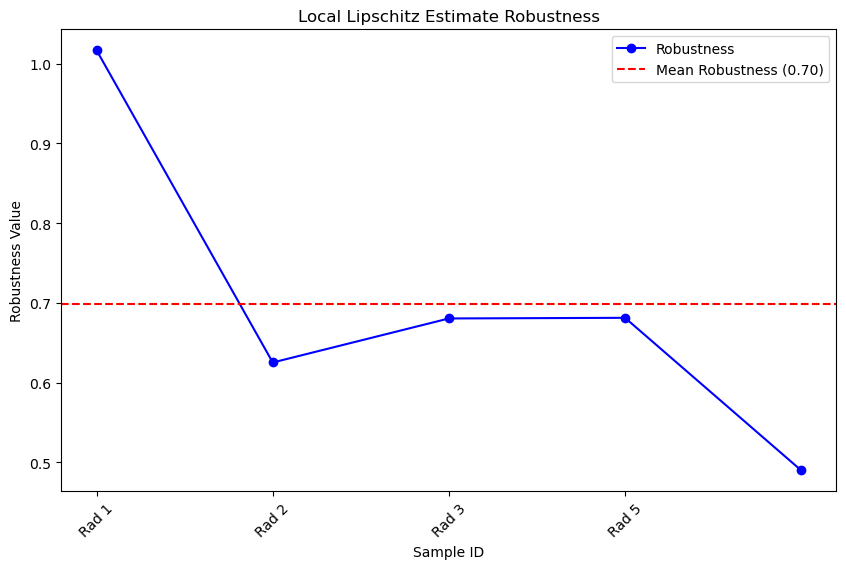

In [77]:
# Extract the labels from the DataFrame
x_labels = [f"Rad {int(re.search(r'Rad_(\d+)', path).group(1))}" for path in ground_truth_images_df["path"]]

# Calculate the mean robustness value
mean_robustness = np.mean(robustness)
print(f"Mean Robustness Value: {mean_robustness:.3f}")

# Plot the robustness values
plt.figure(figsize=(10, 6))
plt.plot(robustness, marker='o', linestyle='-', color='b', label='Robustness')
plt.axhline(y=mean_robustness, color='r', linestyle='--', label=f'Mean Robustness ({mean_robustness:.2f})')
plt.title('Local Lipschitz Estimate Robustness')
plt.xlabel('Sample ID')
plt.ylabel('Robustness Value')
plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=45)
plt.legend()
plt.grid(False)
plt.show()

### Complexity:  complexity (Bhatt et al., 2020)

In [63]:
# Define the Complexity metric for evaluating the model's explanations
complexity = quantus.Complexity(
    return_aggregate=True  # Return the aggregate complexity score
)

# Evaluate the complexity of the model's explanations
comp_score = complexity(
    model=wrapped_model,  # The wrapped model to evaluate
    x_batch=x_batch,  # Batch of input images
    y_batch=y_batch,  # Batch of true labels
    a_batch=a_batch,  # Batch of saliency maps
    **{"device": device}  # Additional arguments (e.g., device)
)


comp_score = comp_score[0]
print(f"The model {model_name} Complexity Score is: {comp_score:.3f}")

The model densenet169 Complexity Score is: 9.044


### Faithfulness: pixel-flipping (Bach et al., 2015)

In [78]:
# Define the Pixel Flipping metric for evaluating the model's explanations
pixel_flipping = quantus.PixelFlipping(
    features_in_step=224,  # Number of features to flip in each step
    perturb_baseline="black",  # Baseline color for perturbation
    perturb_func=quantus.perturb_func.baseline_replacement_by_indices,  # Function to apply perturbation
)

# Call the metric instance to produce scores
scores = pixel_flipping(
    model=wrapped_model,  # The wrapped model to evaluate
    x_batch=x_batch,  # Batch of input images
    y_batch=y_batch,  # Batch of true labels
    a_batch=a_batch,  # Batch of saliency maps
    device=device  # Device to run the evaluation on
)

Mean of the smoothed scores: 0.552


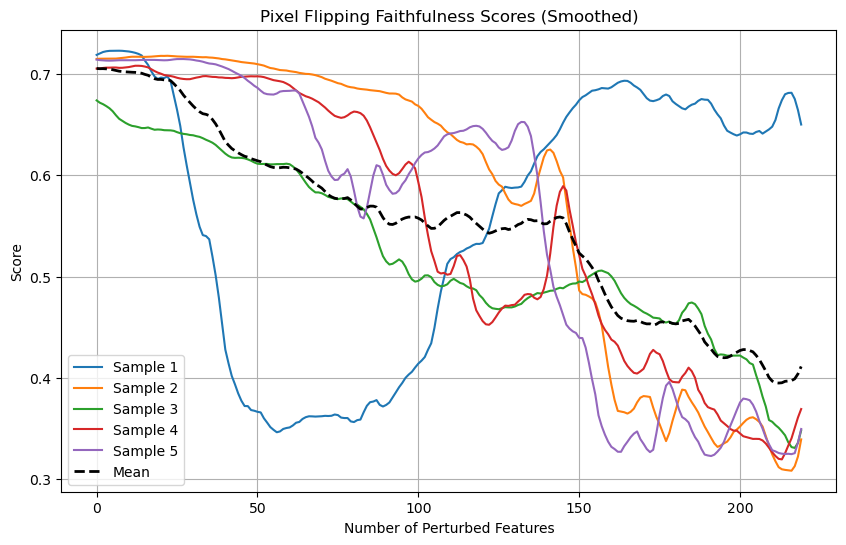

In [79]:
def moving_average(data, window_size):
    """Compute the moving average of the data."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot the PixelFlipping scores with smoothing
plt.figure(figsize=(10, 6))
window_size = 5  # Adjust the window size for smoothing
all_smoothed_scores = []

for i, score in enumerate(scores):
    smoothed_score = moving_average(score, window_size)
    all_smoothed_scores.append(smoothed_score)
    plt.plot(smoothed_score, label=f'Sample {i+1}')

# Calculate and plot the mean of the smoothed scores
mean_smoothed_score = np.mean(all_smoothed_scores, axis=0)
plt.plot(mean_smoothed_score, label='Mean', color='black', linestyle='--', linewidth=2)

mean_of_means = np.mean(mean_smoothed_score)
print(f"Mean of the smoothed scores: {mean_of_means:.3f}")

plt.title('Pixel Flipping Faithfulness Scores (Smoothed)')
plt.xlabel('Number of Perturbed Features')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

### Randomisation: model parameter randomisation test (Adebayo et al., 2018)

In [95]:
# Custom aggregation function to debug NaN values
def custom_aggregation(scores_list):
    print("Layer-wise MPRT Scores:")
    print(f"scores_list: {scores_list}")
    valid_scores = []
    for score in scores_list:
        print(score)
        
        # Check for NaN values
        if not np.isnan(score):
            valid_scores.append(score)

    if not valid_scores:
        print("All scores are NaN! Returning NaN.")
        return np.nan  # Avoid computing if all are NaN

    # Compute a robust aggregate score (e.g., mean of valid values)
    return np.mean(valid_scores)

# Define the Model Parameter Randomisation Test (MPRT) metric with custom aggregation
metric_randomisation = quantus.MPRT(abs=True, 
                                    return_aggregate=True,
                                    return_average_correlation=True,
                                    aggregate_func=custom_aggregation)

# Evaluate the randomisation score of the model's explanations
randomisation_score = metric_randomisation(
    model=wrapped_model,  
    x_batch=x_batch,  
    y_batch=y_batch,  
    a_batch=np.array(a_batch),  
    device=device,  
    explain_func=generate_saliency_map_,
)


# Output the aggregated randomisation score
print("\nFinal Aggregated Randomisation Score:", randomisation_score)
mean_randomisation_score = np.mean(randomisation_score)
print(f"Mean Randomisation Score: {mean_randomisation_score:.3f}")

c:\Users\bar24\anaconda3\envs\ExplainableAI\Lib\site-packages\quantus\functions\similarity_func.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return scipy.stats.spearmanr(a, b)[0]


Layer-wise MPRT Scores:
scores_list: [-0.02454992792247912, nan, nan, nan, nan]
-0.02454992792247912
nan
nan
nan
nan

Final Aggregated Randomisation Score: [-0.02454992792247912]
Mean Randomisation Score: -0.025


### Localisation: relevance mass accuracy (Arras et al., 2021)

In [96]:
# Initialize an empty list to store the masks
s_batch = []

# Iterate over all ground truth images
for i in range(all_ground_truth_images.shape[0]):

    # Define the target size for resizing
    target_size = (224, 224)

    # Get the image path and actual label
    image_path = all_ground_truth_images.iloc[i]['path']
    actual_label = all_ground_truth_images.iloc[i]["Pleural Effusion"]

    # Get the original dimensions of the image
    original_width, original_height = Image.open(image_path).size

    # Calculate the scaling factors for resizing
    scale_x = target_size[0] / original_width
    scale_y = target_size[1] / original_height

    # Get the bounding box coordinates and rescale them
    x_start, y_start, x_end, y_end = all_attributes_list[i].iloc[1], all_attributes_list[i].iloc[2], all_attributes_list[i].iloc[3], all_attributes_list[i].iloc[4]
    x_start_rescaled = int(x_start * scale_x)
    y_start_rescaled = int(y_start * scale_y)
    x_end_rescaled = int(x_end * scale_x)
    y_end_rescaled = int(y_end * scale_y)

    # Create a mask with the target size
    mask = np.zeros((target_size[1], target_size[0]), dtype=np.float32)  # (224, 224)

    # Set the bounding box area in the mask to 1
    mask[y_start_rescaled:y_end_rescaled, x_start_rescaled:x_end_rescaled] = 1.0

    # Append the mask to the list
    s_batch.append(mask)
    
    # Print mask details for debugging
    print(f"Mask shape: {mask.shape}")
    print(f"Mask has non-zero elements: {np.any(mask > 0)}")
    print(f"Mask sum: {np.sum(mask)}")

# Convert the list of masks to a numpy array and add a new axis
s_batch = np.array(s_batch)
s_batch = np.expand_dims(s_batch, axis=1)  # New shape: (5, 1, 224, 224)

# Define the Relevance Mass Accuracy metric
relevance_mass_accuracy = quantus.RelevanceMassAccuracy()

# Evaluate the localisation using the Relevance Mass Accuracy metric
localisation = relevance_mass_accuracy(
    model=model, 
    x_batch=x_batch, 
    y_batch=y_batch, 
    a_batch=a_batch, 
    s_batch=s_batch,
    explain_func=generate_saliency_map_,  
    device=device
)

Mask shape: (224, 224)
Mask has non-zero elements: True
Mask sum: 5963.0
Mask shape: (224, 224)
Mask has non-zero elements: True
Mask sum: 7020.0
Mask shape: (224, 224)
Mask has non-zero elements: True
Mask sum: 7020.0
Mask shape: (224, 224)
Mask has non-zero elements: True
Mask sum: 7878.0
Mask shape: (224, 224)
Mask has non-zero elements: True
Mask sum: 4368.0


Mean Localisation Value: 0.069


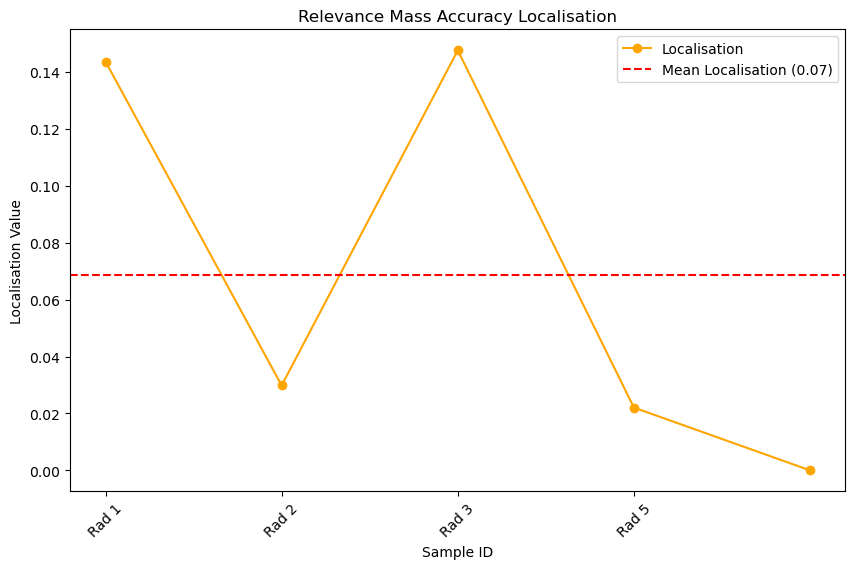

In [97]:
# Extract the labels from the DataFrame
x_labels = [f"Rad {int(re.search(r'Rad_(\d+)', path).group(1))}" for path in ground_truth_images_df["path"]]

# Calculate the mean localization value
mean_localisation = np.mean(localisation)
print(f"Mean Localisation Value: {mean_localisation:.3f}")

# Plot the localization values
plt.figure(figsize=(10, 6))
plt.plot(localisation, marker='o', linestyle='-', color='orange', label='Localisation')
plt.axhline(y=mean_localisation, color='r', linestyle='--', label=f'Mean Localisation ({mean_localisation:.2f})')
plt.title('Relevance Mass Accuracy Localisation')
plt.xlabel('Sample ID')
plt.ylabel('Localisation Value')
plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=45)
plt.legend()
plt.grid(False)
plt.show()